In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import IntegerType, DoubleType, BooleanType, StringType, TimestampType

spark = SparkSession.Builder().appName('DDAM_Project_est').getOrCreate()
sqlCtx = SQLContext(spark)
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/East_Incidents.csv')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/18 17:02:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
df.show()

23/12/18 16:36:55 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+-------+--------+-------------------+-------------------+------------------+------------------+-------+-------+------------------+--------------------+--------------------+-----------+-------------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|      ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|End_Lat|End_Lng|      Distance(mi)|         Description|              Street|       City|       County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation

In [3]:
# Remove not interesting variables
to_delete=['ID','Source','Country','Weather_TimeStamp','End_Time','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','End_Lat','End_Lng','Description','Timezone','Street','Zipcode','Airport_Code']
for col in to_delete:
    df = df.drop(col)

# VARIABLES EXPLORATION

In [4]:
summary = df.describe().toPandas().T
summary

0                     1                     2  \
summary                 count                  mean                stddev   
Severity               431962    2.0764187590575096    0.4499004796606926   
Start_Lat              431962     37.99145821228733     2.812277991839304   
Start_Lng              431962    -77.82622599427887     2.744489551602085   
Distance(mi)           431962    0.8781626995162669    1.7760172485721302   
City                   431961                  None                  None   
County                 431962                  None                  None   
State                  431962                  None                  None   
Temperature(F)         422110     60.75001066072824     18.88850491930701   
Wind_Chill(F)          419273    59.384448795891934    21.031681176001435   
Humidity(%)            421312     64.26847324548078     22.07090204742208   
Pressure(in)           422382    29.547528280087604    0.5721390533760334   
Visibility(mi)         421611     9.101967738033398     2.455733832419407   
Wind_Direction         420186                  None                  None   
Wind_Speed(mph)        420188    7.1174498081810995     5.250878570885647   
Precipitation(in)      422930  0.006294705979712832  0.040926296843998955   
Weather_Condition      422223                  None                  None   
Astronomical_Twilight  428360                  None                  None   

                                  3                   4  
summary                         min                 max  
Severity                          1                   4  
Start_Lat                 32.103479           45.001892  
Start_Lng                -84.308337          -72.023992  
Distance(mi)                    0.0             112.903  
City                     Aaronsburg                Zuni  
County                    Abbeville                York  
State                            NC                  VA  
Temperature(F)                 -8.0               172.0  
Wind_Chill(F)                 -35.0               172.0  
Humidity(%)                     1.0               100.0  
Pressure(in)                  19.64               57.54  
Visibility(mi)                  0.0                20.0  
Wind_Direction                 CALM                 WSW  
Wind_Speed(mph)                 0.0               105.0  
Precipitation(in)               0.0                2.74  
Weather_Condition      Blowing Snow  Wintry Mix / Windy  
Astronomical_Twilight           Day               Night

In [5]:
df.dtypes

[('Severity', 'int'),
 ('Start_Time', 'timestamp'),
 ('Start_Lat', 'double'),
 ('Start_Lng', 'double'),
 ('Distance(mi)', 'double'),
 ('City', 'string'),
 ('County', 'string'),
 ('State', 'string'),
 ('Temperature(F)', 'double'),
 ('Wind_Chill(F)', 'double'),
 ('Humidity(%)', 'double'),
 ('Pressure(in)', 'double'),
 ('Visibility(mi)', 'double'),
 ('Wind_Direction', 'string'),
 ('Wind_Speed(mph)', 'double'),
 ('Precipitation(in)', 'double'),
 ('Weather_Condition', 'string'),
 ('Amenity', 'boolean'),
 ('Bump', 'boolean'),
 ('Crossing', 'boolean'),
 ('Give_Way', 'boolean'),
 ('Junction', 'boolean'),
 ('No_Exit', 'boolean'),
 ('Railway', 'boolean'),
 ('Roundabout', 'boolean'),
 ('Station', 'boolean'),
 ('Stop', 'boolean'),
 ('Traffic_Calming', 'boolean'),
 ('Traffic_Signal', 'boolean'),
 ('Turning_Loop', 'boolean'),
 ('Astronomical_Twilight', 'string')]

In [6]:
rows = df.count()
cols = len(df.columns)
print(f'Il Dataset contiene {rows} records e {cols} colonne, il tutto da ripulire poichè presenta valori nulli e presumibilmente altamente correlati')

Il Dataset contiene 431962 records e 31 colonne, il tutto da ripulire poichè presenta valori nulli e presumibilmente altamente correlati


In [7]:
column_types = dict(df.dtypes)

numeric_columns = []
boolean_columns = []
string_columns = []
timestamp_columns = []

for column, data_type in column_types.items():
    if data_type == 'int' or data_type == 'double':
        numeric_columns.append(column)
    elif data_type == 'boolean':
        boolean_columns.append(column)
    elif data_type == 'string':
        string_columns.append(column)
    elif data_type == 'timestamp':
        timestamp_columns.append(column)

# Mostra i risultati
print("Colonnes numeriche:", numeric_columns), print(len(numeric_columns))
print("Colonnes booleane:", boolean_columns), print(len(boolean_columns))
print("Colonnes stringhe:", string_columns), print(len(string_columns))
print("Colonnes timestamp:", timestamp_columns), print(len(timestamp_columns))

print("Numero totale di colonne:", len(df.columns))

Colonnes numeriche: ['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']
11
Colonnes booleane: ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop']
13
Colonnes stringhe: ['City', 'County', 'State', 'Wind_Direction', 'Weather_Condition', 'Astronomical_Twilight']
6
Colonnes timestamp: ['Start_Time']
1
Numero totale di colonne: 31


In [8]:
unique_weather_conditions = df.select("Weather_Condition").distinct().collect()
# Mostra i valori unici
for row in unique_weather_conditions:
    print(row["Weather_Condition"])

CodeCache: size=131072Kb used=32802Kb max_used=32898Kb free=98269Kb
 bounds [0x000000010b1d8000, 0x000000010d248000, 0x00000001131d8000]
 total_blobs=12090 nmethods=11143 adapters=858
 compilation: disabled (not enough contiguous free space left)
Shallow Fog
Light Sleet
Light Snow / Windy
N/A Precipitation
Showers in the Vicinity
Cloudy
Wintry Mix / Windy
T-Storm / Windy
Light Freezing Rain
Wintry Mix
Sleet
Heavy Rain / Windy
Thunder / Windy
Light Rain with Thunder
Heavy T-Storm
Patches of Fog
Drizzle
Cloudy / Windy
T-Storm
Fog
Partly Cloudy
Fair
Heavy Drizzle
Light Drizzle / Windy
Mostly Cloudy
Heavy Snow / Windy
Haze / Windy
Drizzle and Fog
Light Freezing Drizzle
Heavy T-Storm / Windy
Heavy Rain
Freezing Rain
Light Snow and Sleet
Snow and Sleet
Fog / Windy
Snow / Windy
Rain / Windy
Thunder
Light Rain
Mist
Light Rain / Windy
Partly Cloudy / Windy
Rain
Snow
Thunder in the Vicinity
Light Drizzle
Haze
Light Snow
Heavy Snow
Fair / Windy
Mostly Cloudy / Windy
Light Rain Shower
Blowing Snow

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


In [9]:
#Renaming some variables
for col in numeric_columns:
    new_col = (
        col.replace("(mi)", "_mi")
           .replace("(F)", "_F")
           .replace("(%)", "_perc")
           .replace("(in)", "_in")
           .replace("(mph)", "_mph")
    )
    df = df.withColumnRenamed(col, new_col)

# DATA UNDERSTANDING

In [10]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import date_format, month, hour, col

In [11]:
# Count distinct values columns
for col in df.columns:
    x=df.select(col).distinct().count()
    print('Column',col, 'has',x,'distinct values')
    #print(df.select(col).distinct().collect())

Column Severity has 4 distinct values


Column Start_Time has 290276 distinct values
Column Start_Lat has 225869 distinct values


Column Start_Lng has 225614 distinct values
Column Distance_mi has 10507 distinct values
Column City has 3127 distinct values
Column County has 378 distinct values
Column State has 5 distinct values
Column Temperature_F has 116 distinct values
Column Wind_Chill_F has 142 distinct values
Column Humidity_perc has 99 distinct values
Column Pressure_in has 474 distinct values
Column Visibility_mi has 22 distinct values
Column Wind_Direction has 19 distinct values
Column Wind_Speed_mph has 43 distinct values
Column Precipitation_in has 138 distinct values
Column Weather_Condition has 70 distinct values
Column Amenity has 2 distinct values
Column Bump has 2 distinct values
Column Crossing has 2 distinct values
Column Give_Way has 2 distinct values
Column Junction has 2 distinct values
Column No_Exit has 2 distinct values
Column Railway has 2 distinct values
Column Roundabout has 2 distinct values
Column Station has 2 distinct values
Column Stop has 2 distinct values
Column Traffic_Calming ha

In [12]:
from pyspark.sql.functions import col,month,hour
# creo la colonna 'month'
df=df.withColumn("month", month("Start_Time"))
# creo la colonna 'day_of_the_week'
df=df.withColumn("day_of_the_week", date_format("Start_Time",'EEEE'))  
# creo la colonna'hour'
df=df.withColumn("hour", hour("Start_Time"))


def season(month_):
    if month_>=3 and month_<=5:
        return 'Spring'
    elif month_>=6 and month_<=8:
        return 'Summer'
    elif month_>=9 and month_<=11:
        return 'Autumn'
    else:
        return 'Winter'

udf_season = udf(season, StringType())
df = df.withColumn("season", udf_season(col("month")))

In [13]:
from pyspark.sql.functions import col
from pyspark.sql.functions import udf
def workingDay_weekend(day_of):
    ins={'Monday','Tuesday','Wednesday','Thursday','Friday'}
    if day_of in ins:
        return 'WorkingDay'
    else:
        return 'Weekend'

udf_workingDay_weekend = udf(workingDay_weekend, StringType())
df = df.withColumn("Working_Weekend", udf_workingDay_weekend(col("day_of_the_week")))

In [14]:
from pyspark.sql.functions import col, when

# The function has to be adapted for each cases: south,nord,est,ovest of US
def update_weather_values(df):
    df_new = df.withColumn(
        "Weather_Condition",
        when(
            col("Weather_Condition").isin("Fair", "Fair / Windy", "Thunder in the Vicinity", "Showers in the Vicinity"),
            "Normal"
        ).when(
            col("Weather_Condition").isin(
                "Fog", "Smoke", "Smoke / Windy", "Haze", "Shallow Fog",
                "Patches of Fog", "Haze / Windy", "Fog / Windy", "Mist",
                "Widespread Dust", "Widespread Dust / Windy", "Blowing Dust / Windy",
                "Blowing Dust", "Drizzle and Fog", "Shallow Fog / Windy"
            ),
            "Foggy"
        ).when(
            col("Weather_Condition").isin(
                "Cloudy", "Cloudy / Windy", "Partly Cloudy", "Mostly Cloudy",
                "Partly Cloudy / Windy", "Mostly Cloudy / Windy"
            ),
            "Cloudy"
        ).when(
            col("Weather_Condition").isin(
                "Wintry Mix", "Sleet", "Light Snow / Windy", "Snow", "Heavy Snow with Thunder",
                "Light Snow", "Heavy Snow", "Light Freezing Rain", "Light Snow Shower", "Light Snow Shower / Windy",
                "Heavy Snow / Windy", "Snow / Windy", "Small Hail", "Light Snow and Sleet / Windy",
                "Blowing Snow / Windy", "Light Sleet / Windy", "Snow and Thunder",
                "Hail", "Wintry Mix / Windy", "Light Snow with Thunder", "Snow and Sleet / Windy", "Heavy Sleet",
                "Thunder and Hail", "Light Sleet", "Light Snow and Sleet", "Snow and Sleet", "Blowing Snow", "Drifting Snow / Windy"
            ),
            "Snow"
        ).when(
            col("Weather_Condition").isin(
                "Rain", "Light Drizzle", "Light Rain with Thunder", "T-Storm", "Tornado",
                "Drizzle", "Heavy Rain", "Thunder", "Light Rain",
                "Light Rain / Windy", "Rain / Windy", "Heavy Rain / Windy",
                "Heavy T-Storm", "Rain Shower", "Squalls", "Heavy T-Storm / Windy",
                "Heavy Drizzle", "Light Rain Shower", "Light Drizzle / Windy",
                "Light Freezing Rain / Windy", "Drizzle / Windy", "Thunder / Windy",
                "T-Storm / Windy", "N/A Precipitation", "Light Freezing Drizzle", "Freezing Rain", "Freezing Rain / Windy", "Squalls / Windy"
            ),
            "Rain"
        ).otherwise(col("Weather_Condition"))
    )

    return df_new

df = update_weather_values(df)
unique_weather_conditions = df.select("Weather_Condition").distinct().collect()
print('\nWeather_Condition distinct values:')
for row in unique_weather_conditions:
    print(row["Weather_Condition"])


Weather_Condition distinct values:
Foggy
Cloudy
Rain
Snow
Normal
None


In [15]:
# le variabili Turning loop e Bump hanno un unico valore
df=df.drop('Turning_Loop', 'Bump')
len(df.columns)

34

In [16]:
#Checking missing values

from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns])
missing.toPandas().T
missing.show()

+--------+----------+---------+---------+-----------+----+------+-----+-------------+------------+-------------+-----------+-------------+--------------+--------------+----------------+-----------------+-------+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+---------------------+-----+---------------+----+------+---------------+
|Severity|Start_Time|Start_Lat|Start_Lng|Distance_mi|City|County|State|Temperature_F|Wind_Chill_F|Humidity_perc|Pressure_in|Visibility_mi|Wind_Direction|Wind_Speed_mph|Precipitation_in|Weather_Condition|Amenity|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Astronomical_Twilight|month|day_of_the_week|hour|season|Working_Weekend|
+--------+----------+---------+---------+-----------+----+------+-----+-------------+------------+-------------+-----------+-------------+--------------+--------------+----------------+-----------------+-------+--------+--------+-------

## Continuos variables distribution

>>> plotting distribution for Distance_mi


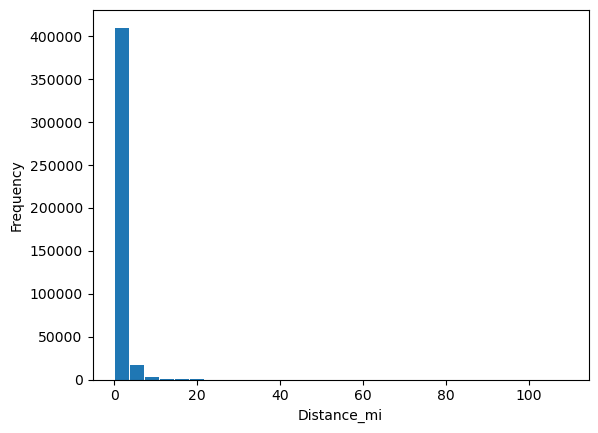

>>> plotting distribution for Temperature_F


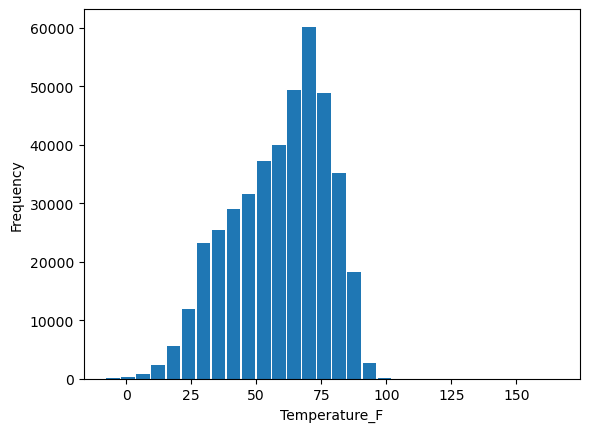

>>> plotting distribution for Wind_Chill_F


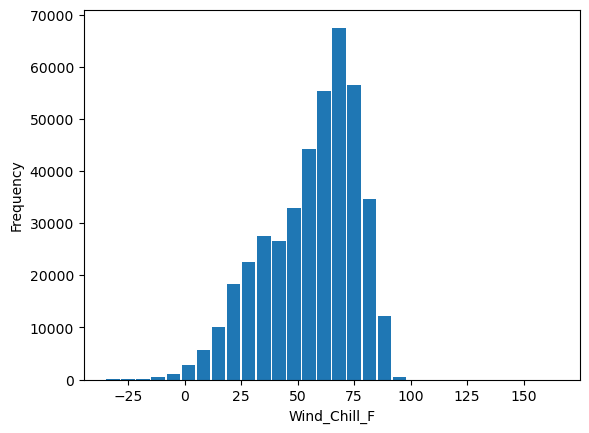

>>> plotting distribution for Humidity_perc


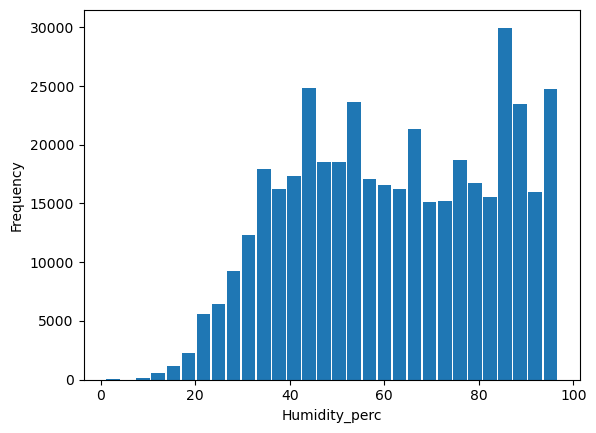

>>> plotting distribution for Pressure_in


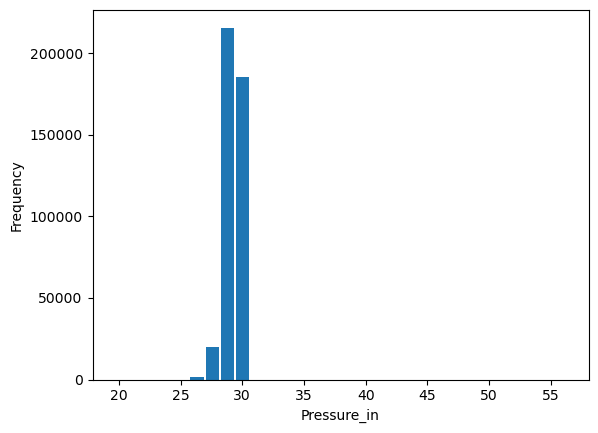

>>> plotting distribution for Visibility_mi


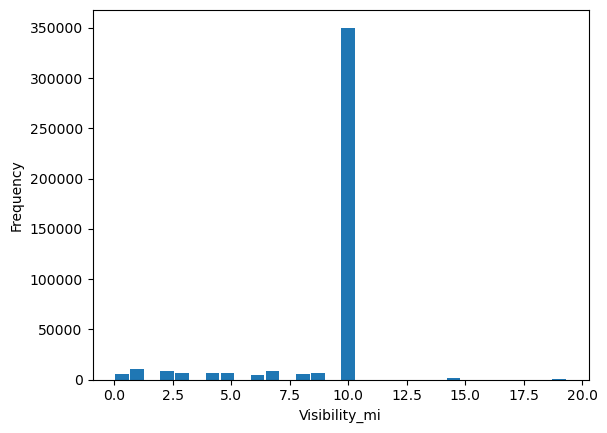

>>> plotting distribution for Wind_Speed_mph


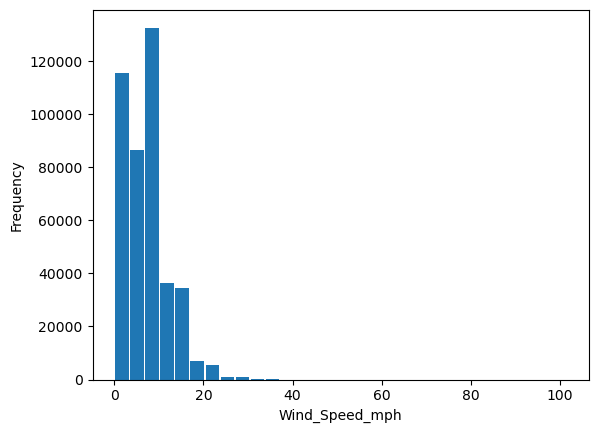

>>> plotting distribution for Precipitation_in


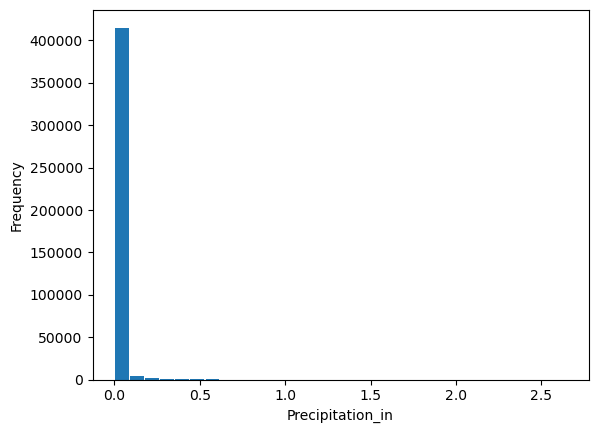

In [17]:
# Analisi distribuzione variabili continue
continuos_features=['Distance_mi', 'Temperature_F', 'Wind_Chill_F', 'Humidity_perc', 'Pressure_in', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
df.createOrReplaceTempView("Incidents_Data")

# Itera attraverso le colonne e crea gli istogrammi
for col in continuos_features:
    print(f">>> plotting distribution for {col}")
    query = spark.sql(f'SELECT {col} FROM Incidents_Data') 
    h = query.select(col).rdd.flatMap(lambda x: x).histogram(30) # seleziono colonna specificata dalla query poi converto tutto in un RDD e applico la funzione flatMap per "appiattire" i valori in un singolo elenco. Infine creo istogramma diviso in 50 bin e restituisco una tupla contenente i bin e le frequenze.
    
    # traspone la tupla ottenuta dall'istogramma per ottenere una lista di tuple, ognuna rappresentante un bin e la sua frequenza.
    dfh = pd.DataFrame(
        list(zip(*h)), 
        columns=['bin', 'frequency']
    )
    # estraggo dai dal dataframe pandas per ottenere i bin e le frequenze necessari per il plotting
    bins = dfh['bin']
    counts = dfh['frequency']
    #  classic pandas syntax
    plt.hist(bins, len(bins), weights=counts, rwidth=0.9)
    plt.xlabel(f'{col}', size=10)
    plt.ylabel("Frequency", size=10)
    #plt.grid(True) 
    plt.show()

## Categoric variables frequency

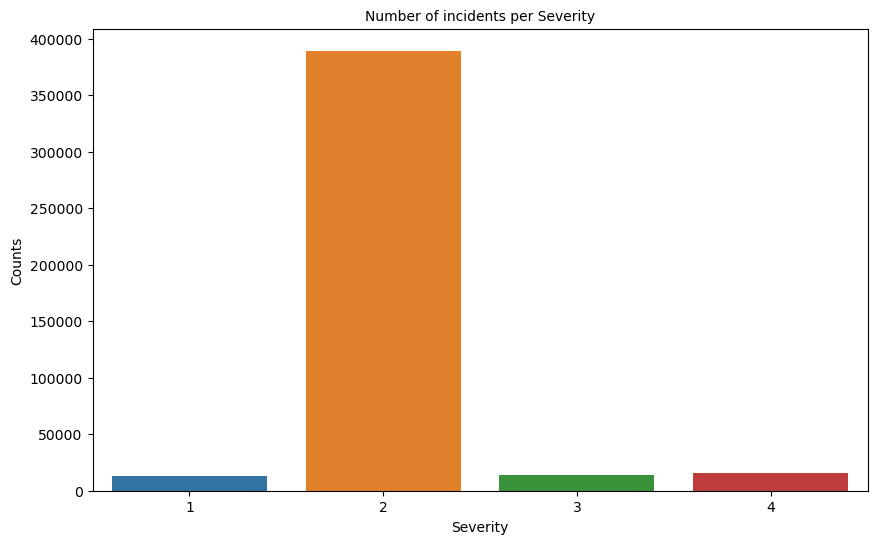

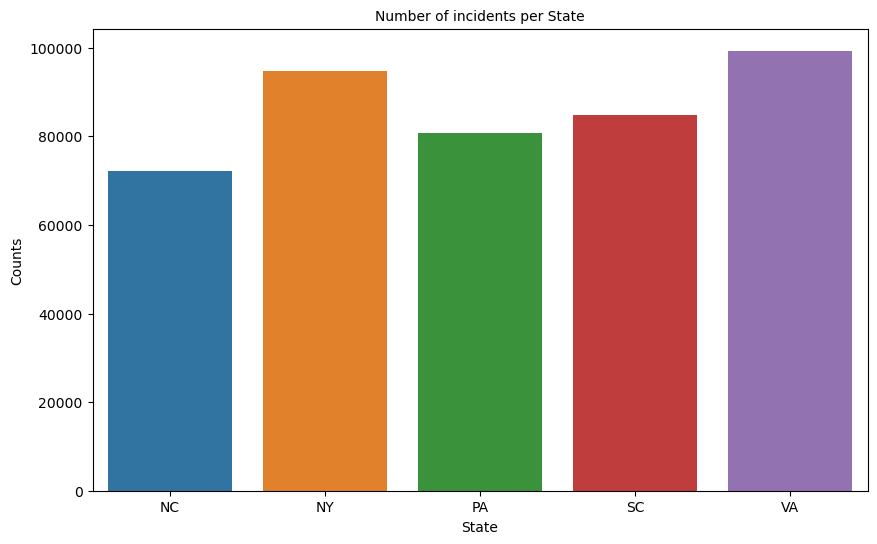

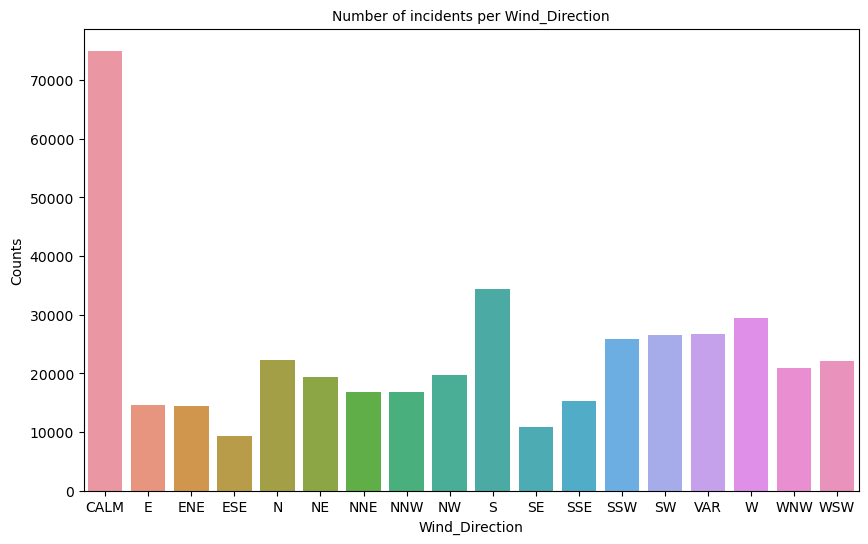

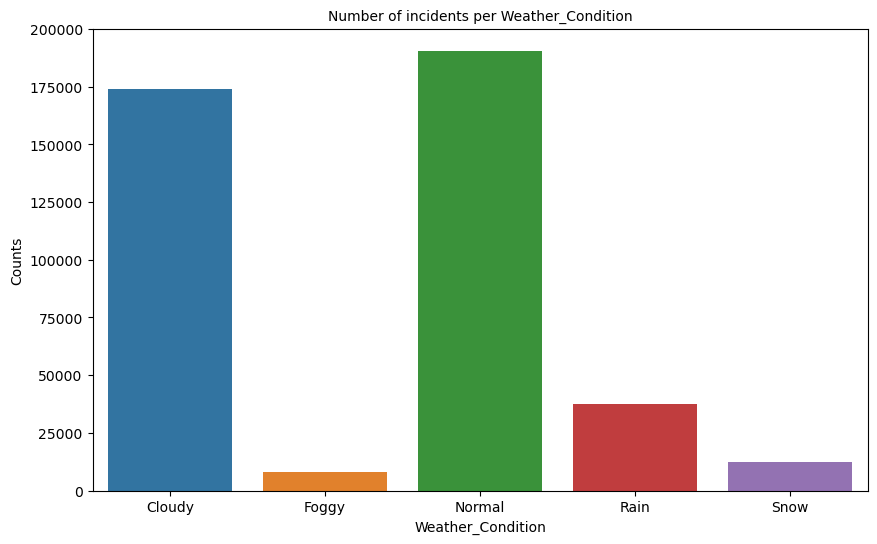

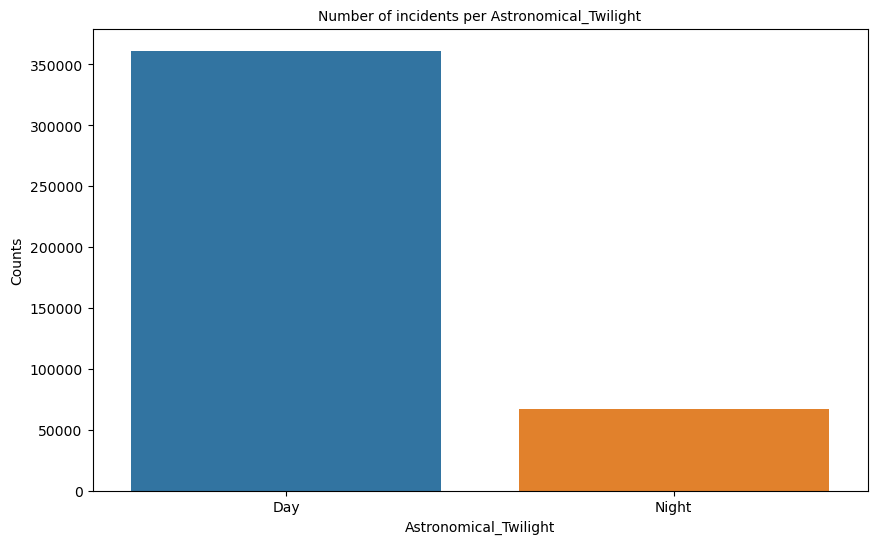

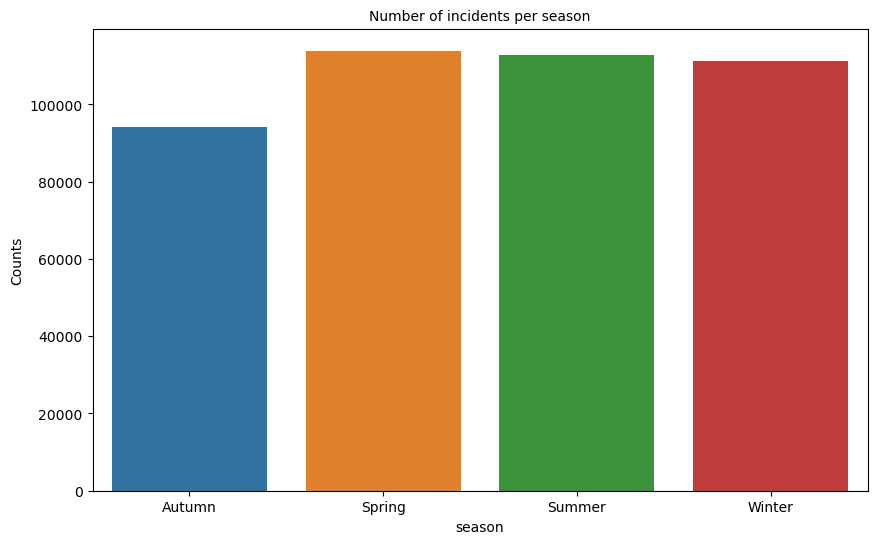

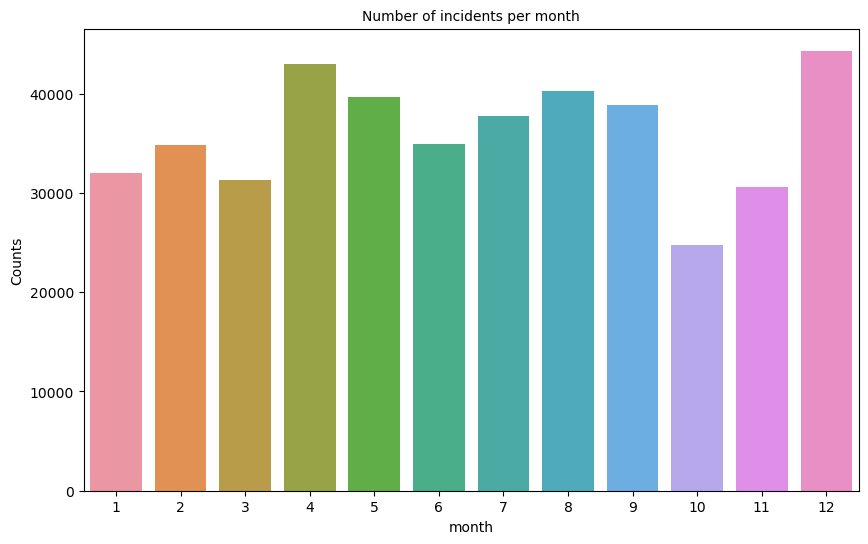

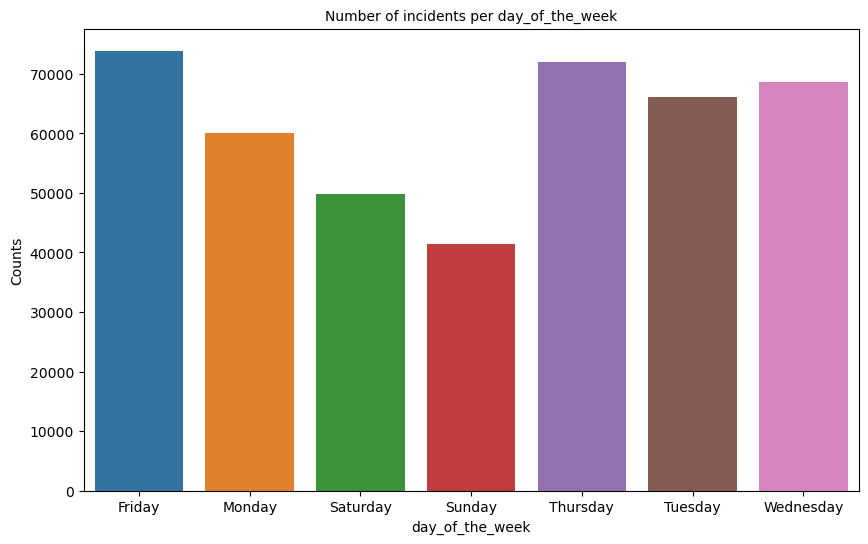

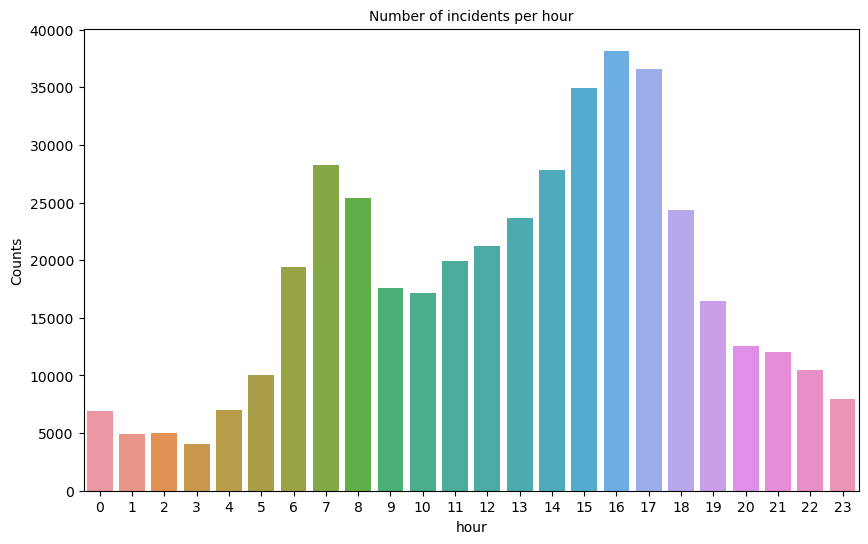

In [18]:
# Analisi barplot variabili categoriche/discrete
discrete_features=['Severity','State', 'Wind_Direction', 'Weather_Condition', 'Astronomical_Twilight','season','month','day_of_the_week','hour']
df.createOrReplaceTempView("Incidents_Data")

for feature in discrete_features:
    feature_freq = spark.sql(f"SELECT {feature}, COUNT(*) as count FROM Incidents_Data GROUP BY {feature}").toPandas()
    feature_freq = feature_freq.sort_values(by=feature)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature, y="count", data=feature_freq)
    plt.xlabel(feature, size=10)
    plt.ylabel("Counts", size=10)
    plt.title(f"Number of incidents per {feature}", size=10)
    plt.show()

## Boolean variables frequency

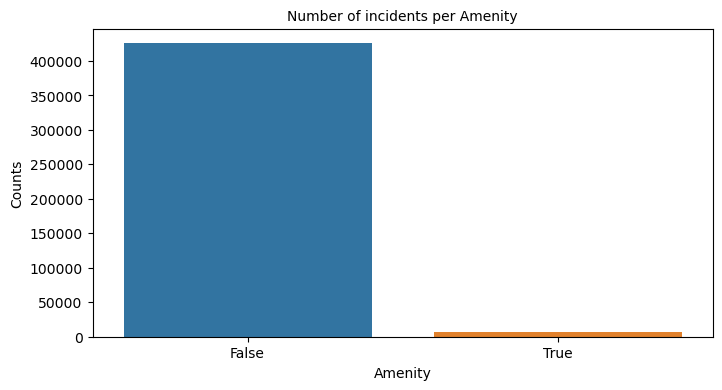

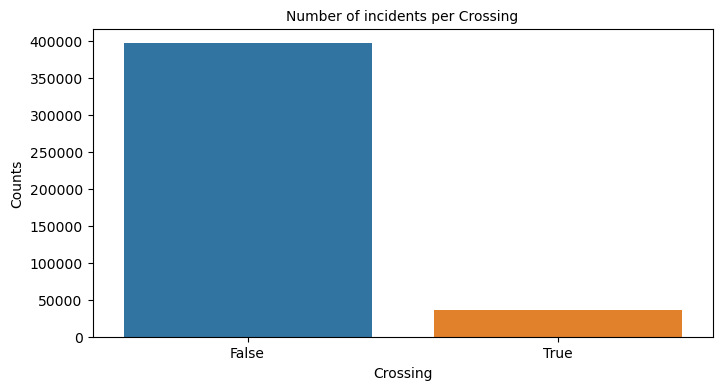

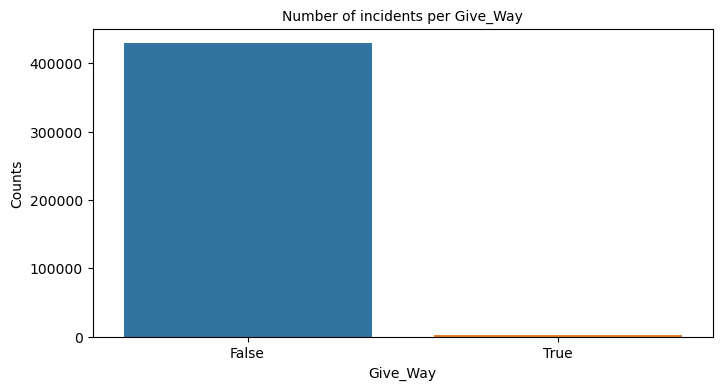

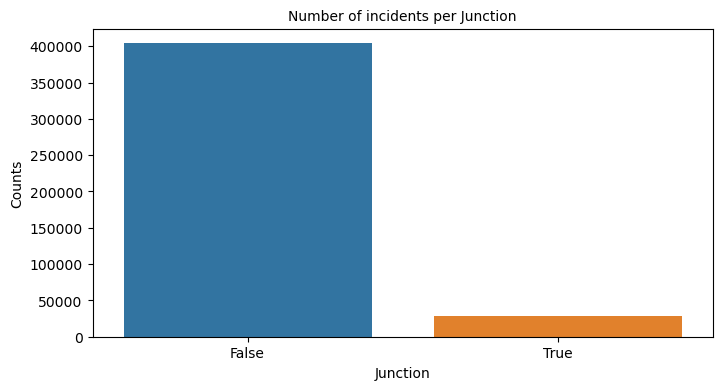

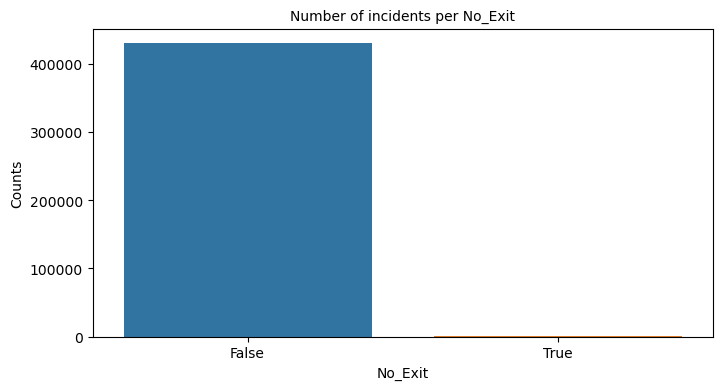

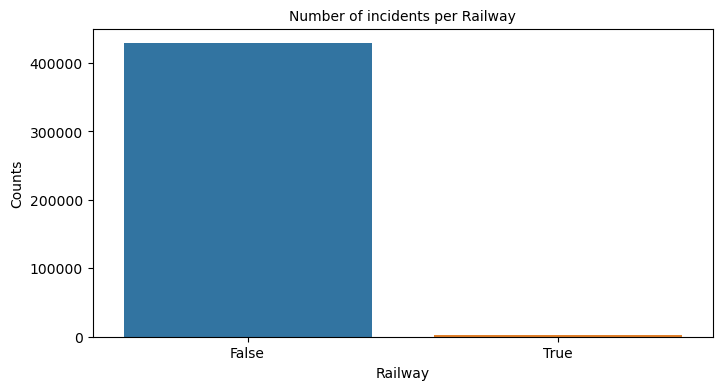

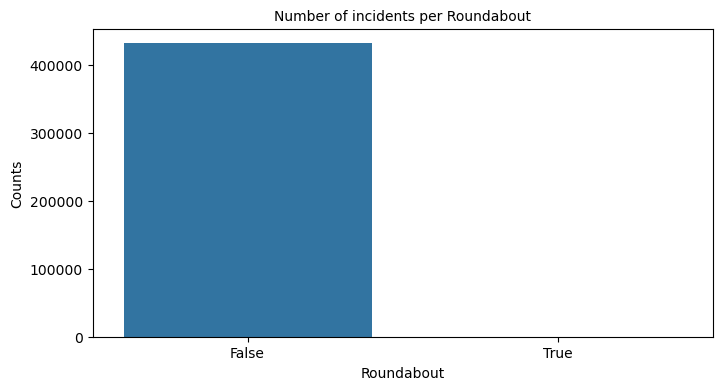

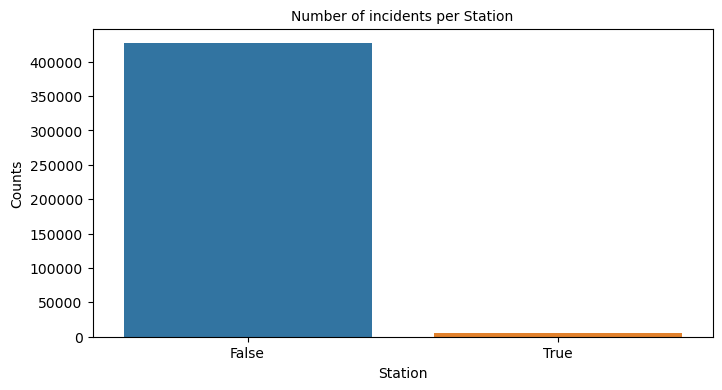

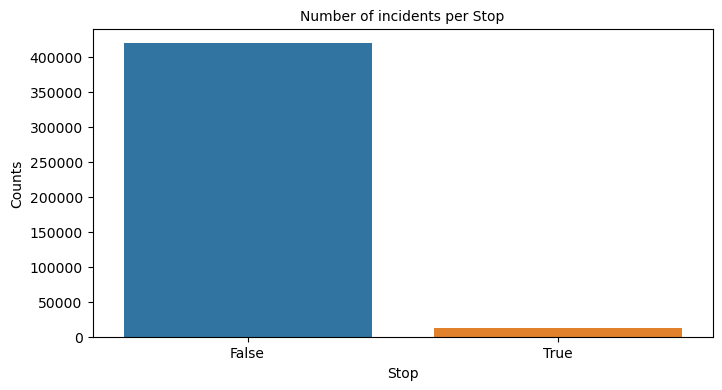

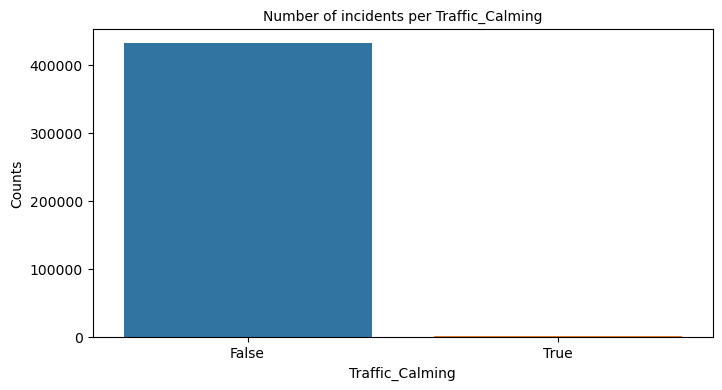

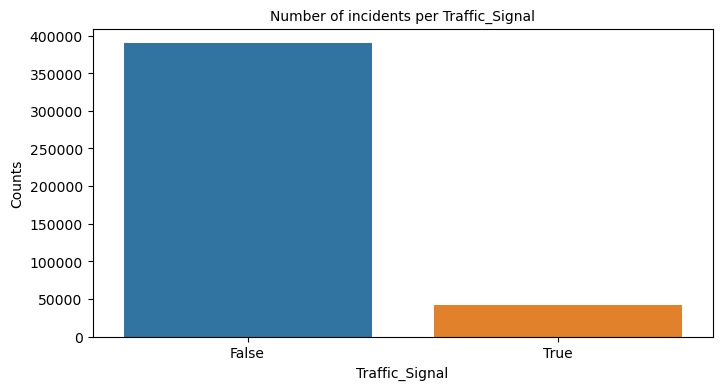

In [19]:
boolean_features=['Amenity', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']
# Analisi barplot variabili booleane
boolean_features=['Amenity','Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']
for feature in boolean_features:
    feature_freq = spark.sql(f"SELECT {feature}, COUNT(*) as count FROM Incidents_Data GROUP BY {feature}").toPandas()
    feature_freq = feature_freq.sort_values(by=feature)
    plt.figure(figsize=(8, 4))
    sns.barplot(x=feature, y="count", data=feature_freq)
    plt.xlabel(feature, size=10)
    plt.ylabel("Counts", size=10)
    plt.title(f"Number of incidents per {feature}", size=10)
    plt.show()

In [20]:
# Per le variabili booleane mi creo anche un dataframe di conteggi per visualizzare meglio i valori binari
df.createOrReplaceTempView("Incidents_Data")
boolean_features = ['Amenity', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal']

results = []

for feature in boolean_features:
    counts = df.groupBy(feature).count().collect()

    for count in counts:
        results.append({'Feature': feature, 'Value': count[feature], 'Count': count['count']})

result_df = spark.createDataFrame(results)
result_df.show(result_df.count(), truncate=False)

+------+---------------+-----+
|Count |Feature        |Value|
+------+---------------+-----+
|6472  |Amenity        |true |
|425490|Amenity        |false|
|35714 |Crossing       |true |
|396248|Crossing       |false|
|2817  |Give_Way       |true |
|429145|Give_Way       |false|
|27990 |Junction       |true |
|403972|Junction       |false|
|1373  |No_Exit        |true |
|430589|No_Exit        |false|
|3245  |Railway        |true |
|428717|Railway        |false|
|431955|Roundabout     |false|
|7     |Roundabout     |true |
|5368  |Station        |true |
|426594|Station        |false|
|11998 |Stop           |true |
|419964|Stop           |false|
|336   |Traffic_Calming|true |
|431626|Traffic_Calming|false|
|42083 |Traffic_Signal |true |
|389879|Traffic_Signal |false|
+------+---------------+-----+



ANALISI AGGIUNTIVE:

1)STATES VS SEVERITY 2)SEASON VS SEVERITY 3)MONTH VS SEVERITY 4)DAY_OF_THE_WEEK VS SEVERITY 5)HOUR VS SEVERITY

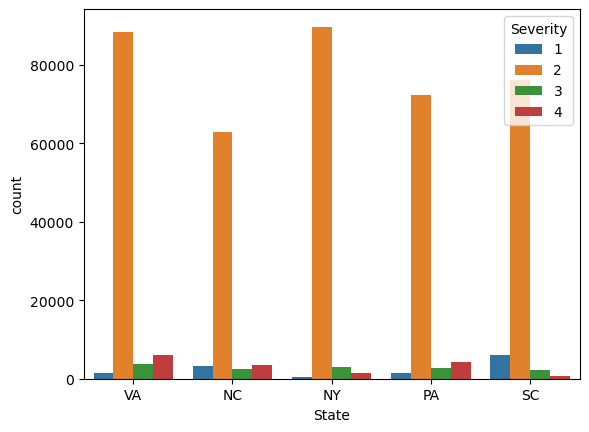

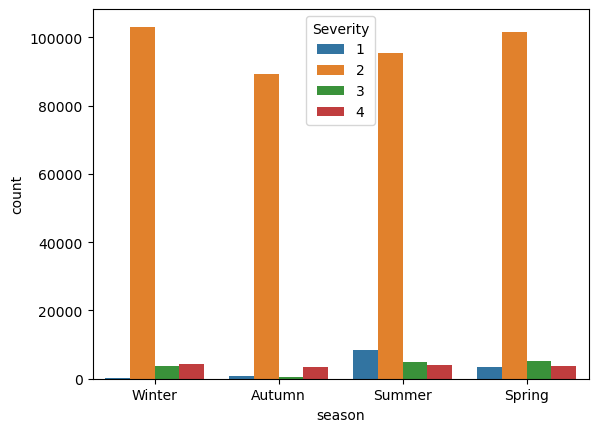

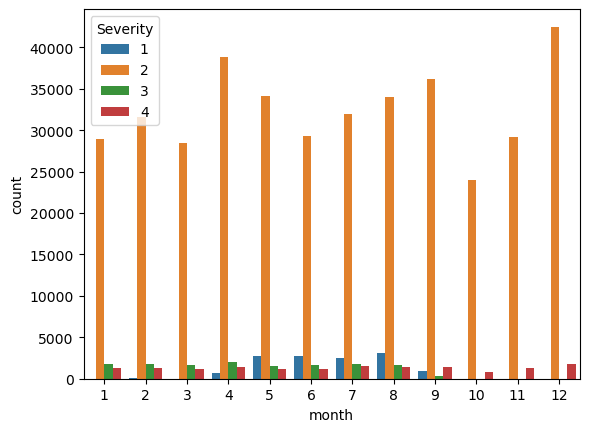

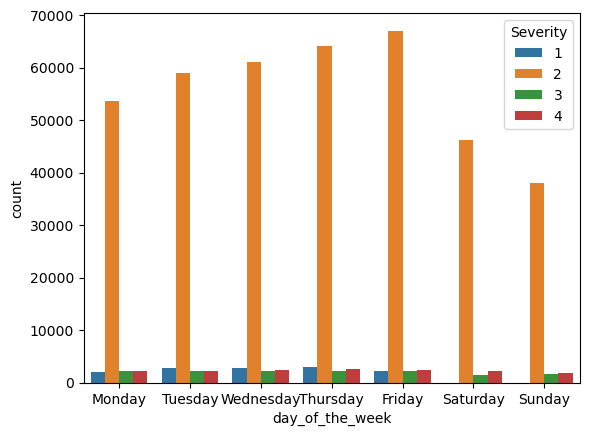

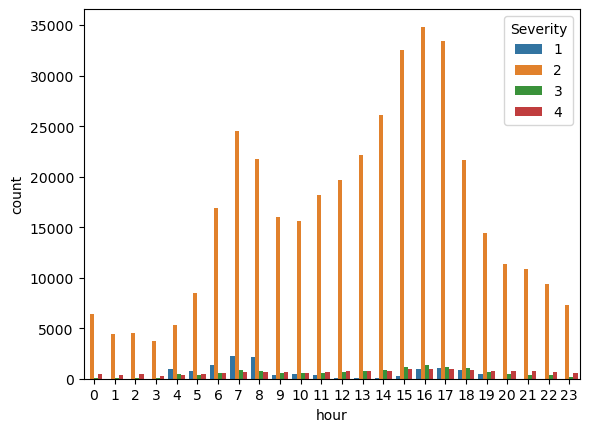

In [21]:
lista = ['State', 'season', 'month', 'day_of_the_week', 'hour']

for col in lista:
    count_ = df.groupBy(col, 'Severity').count().toPandas()
    
    if col == 'day_of_the_week':
        order_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        sns.barplot(x=col, y="count", data=count_, hue='Severity', order=order_of_days)
    else:
        sns.barplot(x=col, y="count", data=count_, hue='Severity')
    
    plt.show()

SCATTER PLOTS

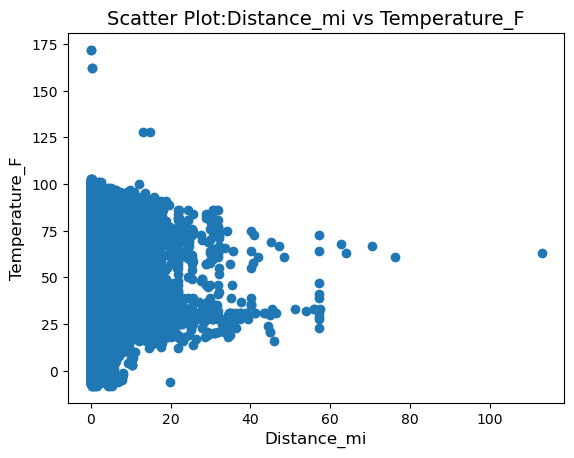

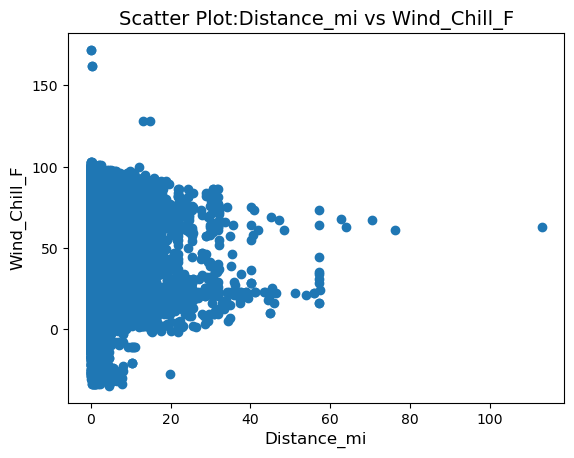

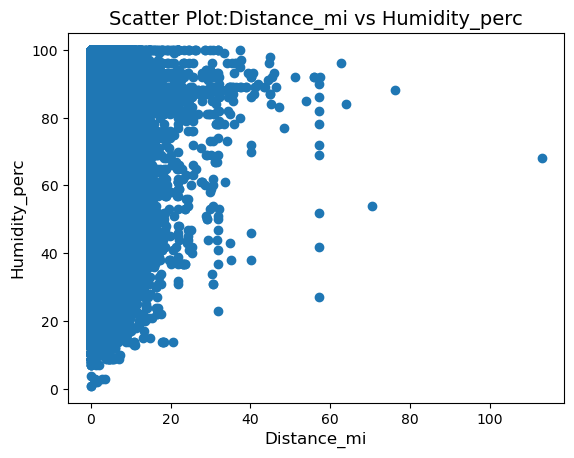

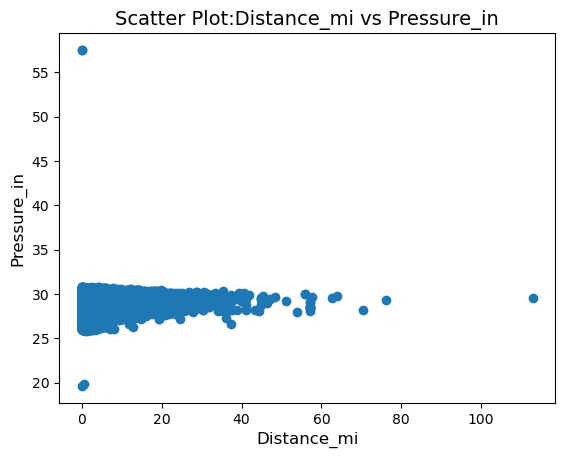

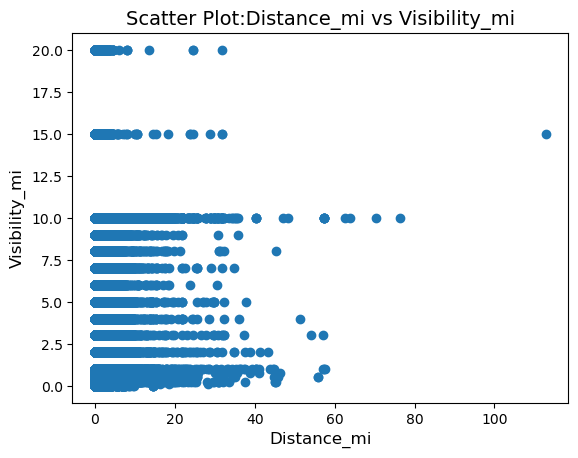

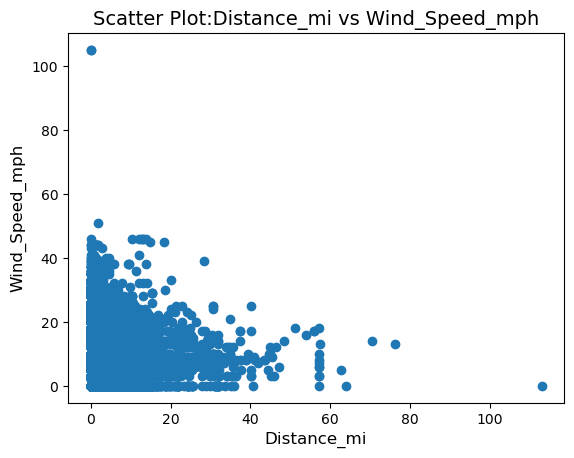

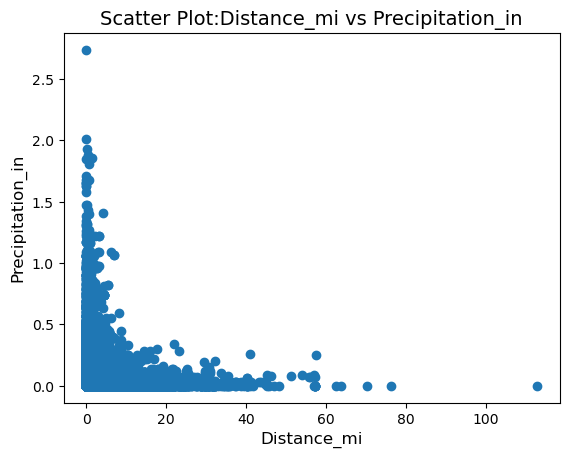

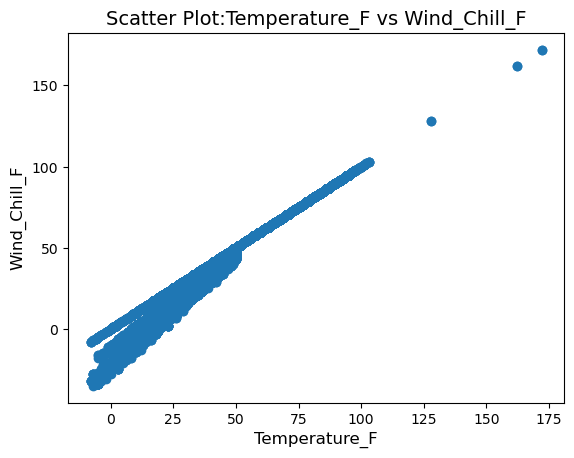

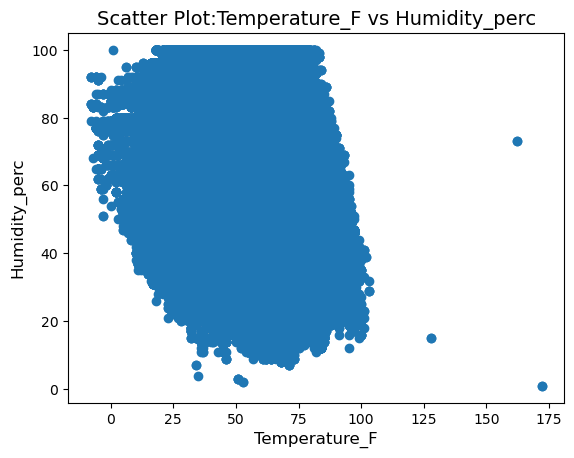

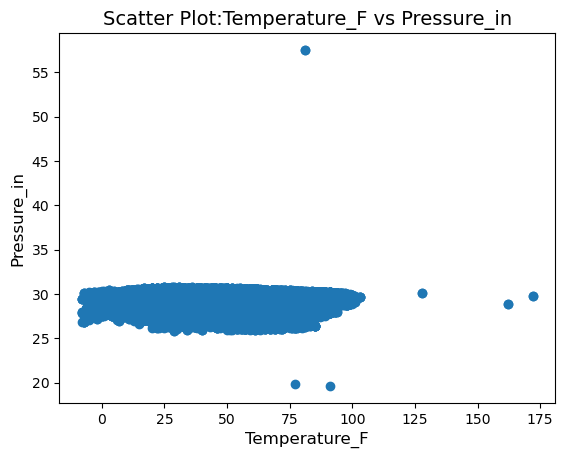

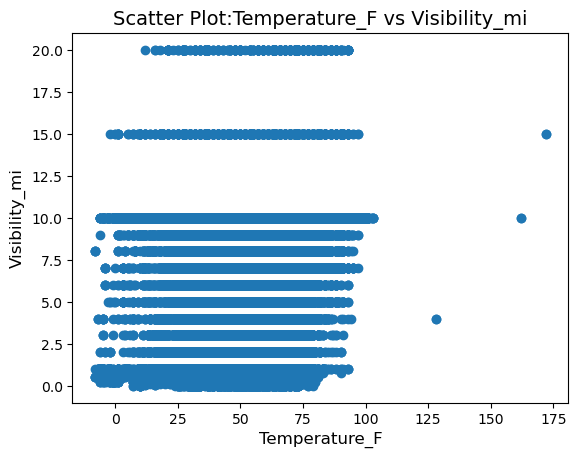

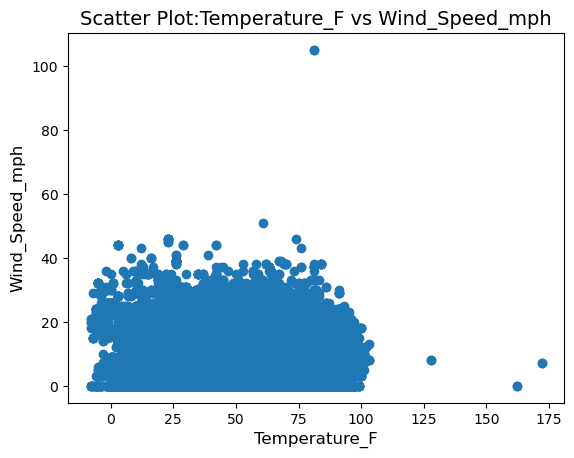

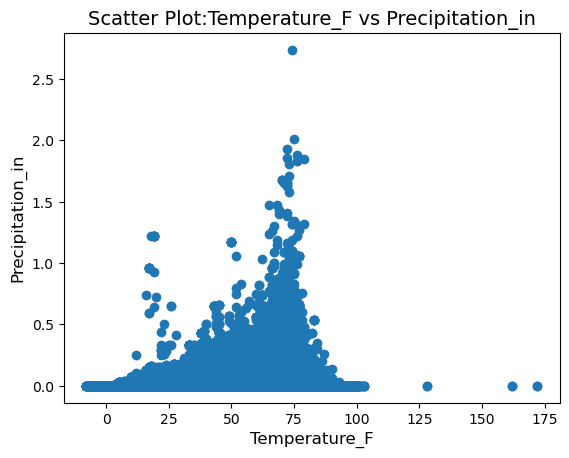

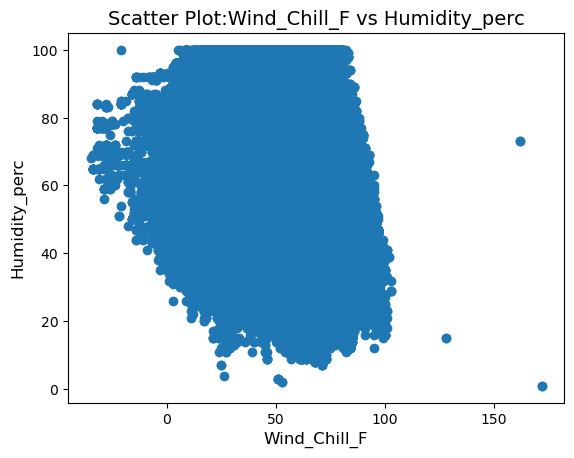

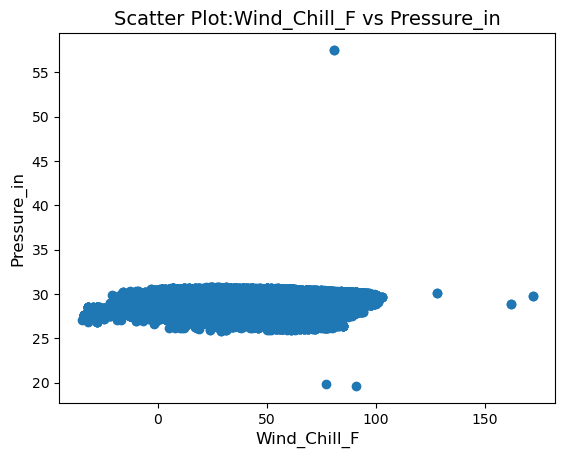

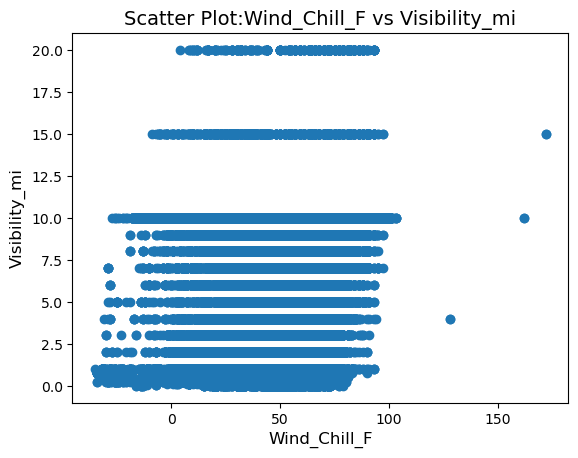

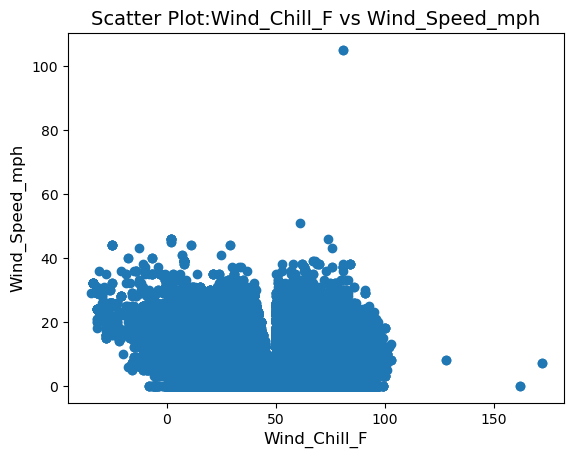

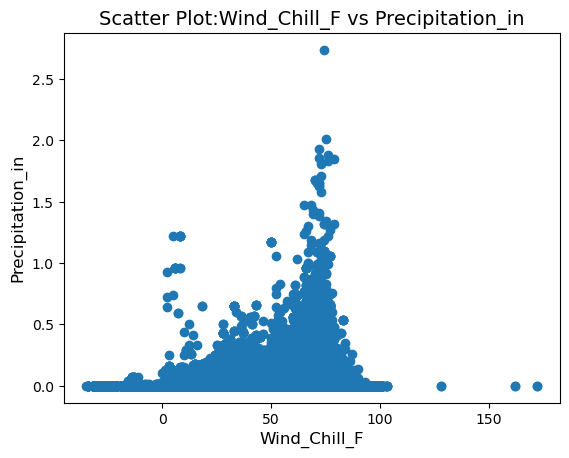

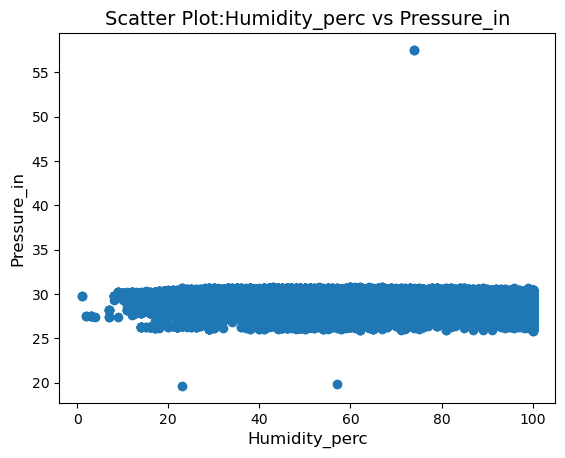

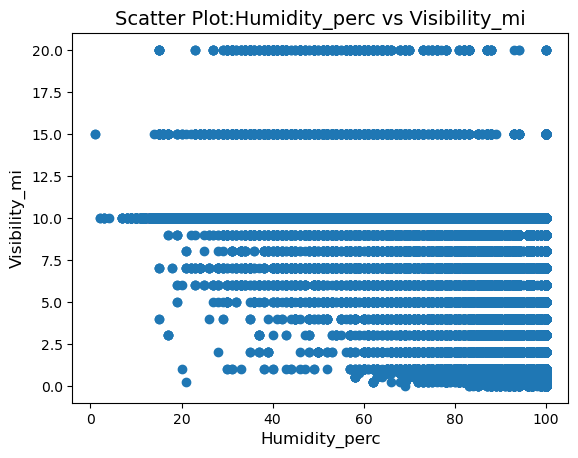

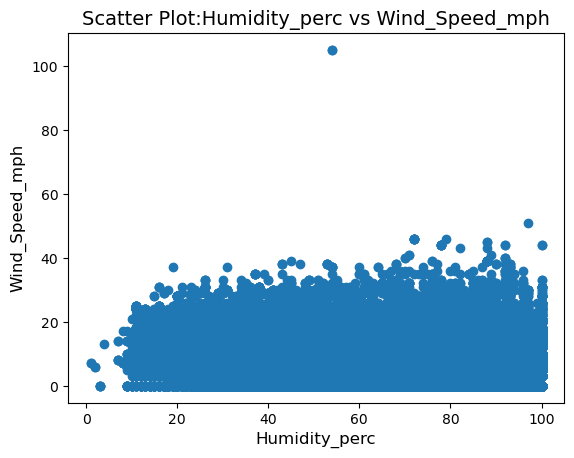

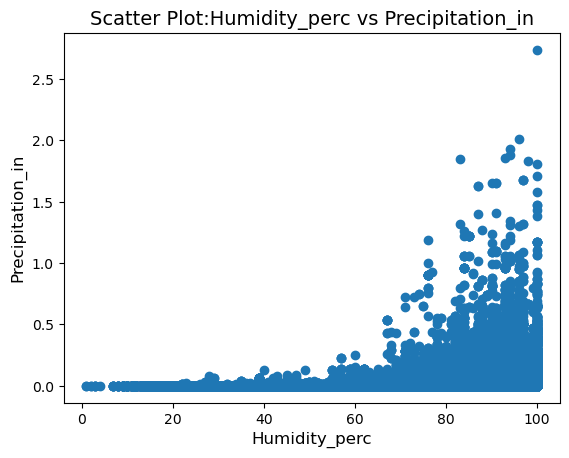

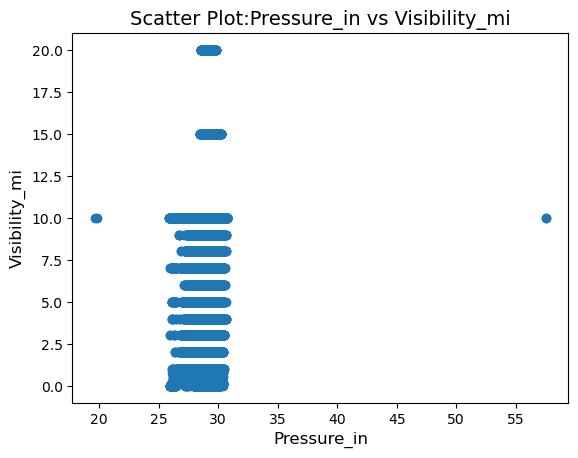

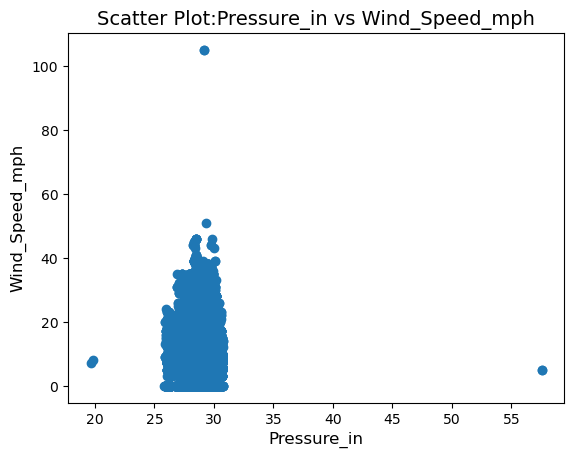

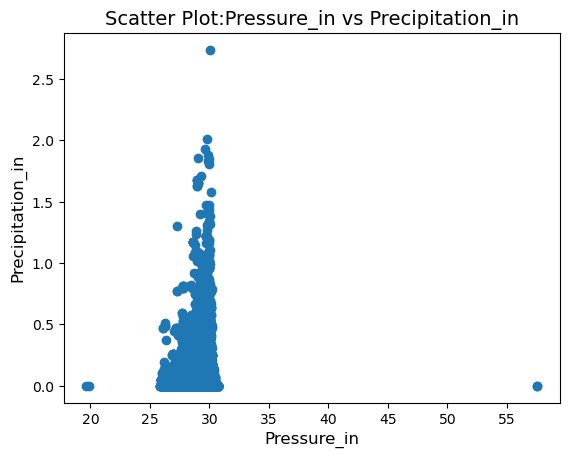

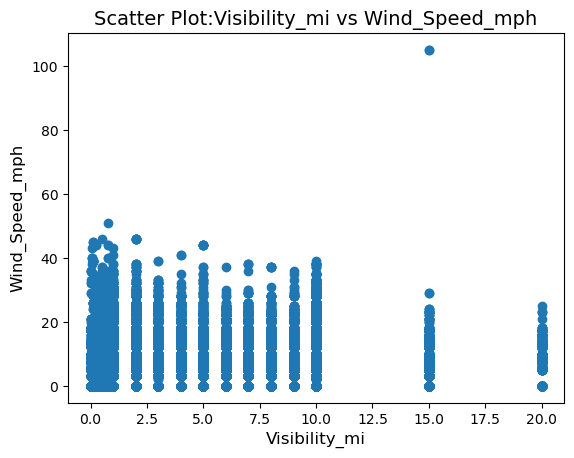

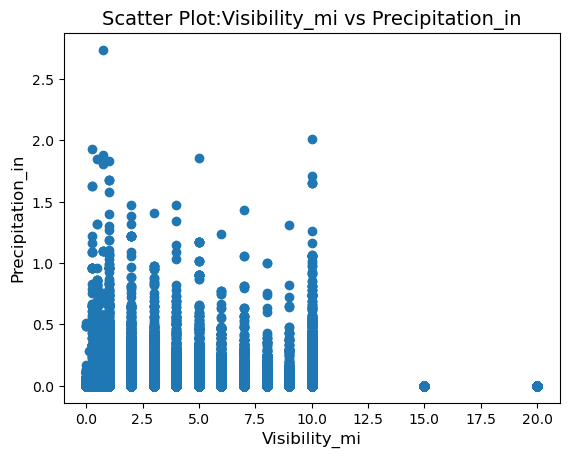

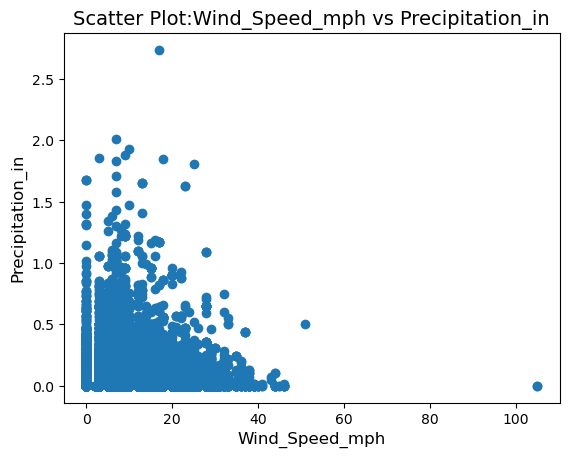

In [22]:
i=0
for el1 in continuos_features:
    for el2 in continuos_features[i+1:]:
        filtered_df = df.filter(df[el1].isNotNull() & df[el2].isNotNull())

        data= filtered_df.select(el1, el2).collect()
        x = [row[el1] for row in data]
        y = [row[el2] for row in data]

        # Crea lo scatterplot utilizzando matplotlib
        plt.scatter(x, y)
        plt.xlabel(el1, size=12)
        plt.ylabel(el2, size=12)
        plt.title("Scatter Plot:"+ el1 +" vs "+el2, size=14)
        plt.show()
    i+=1

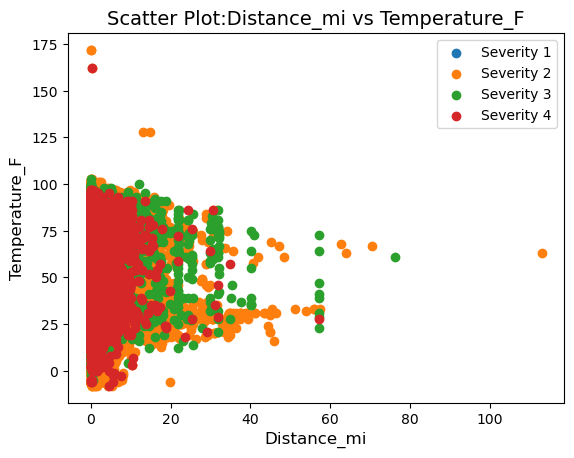

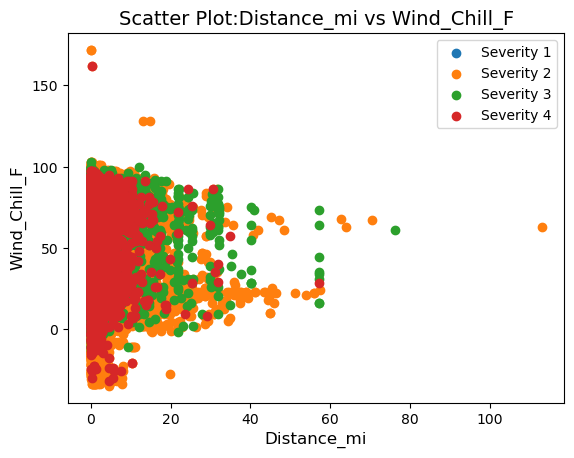

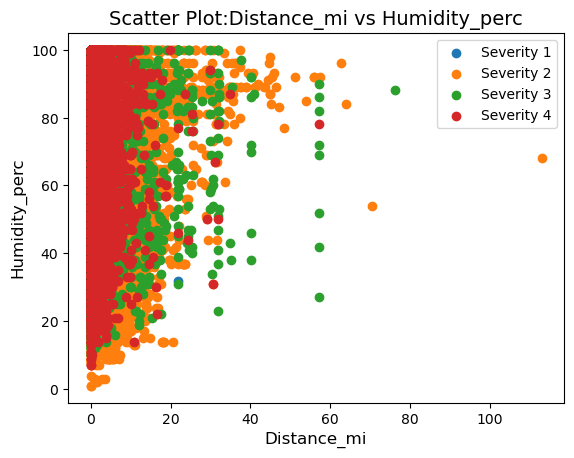

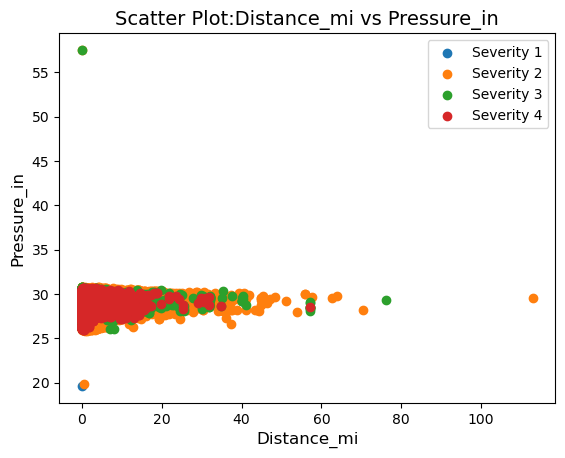

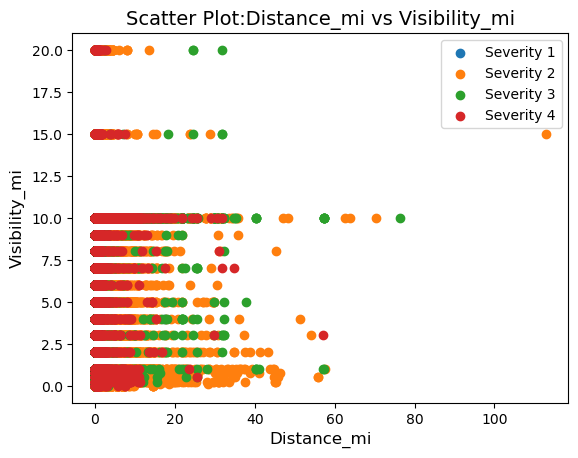

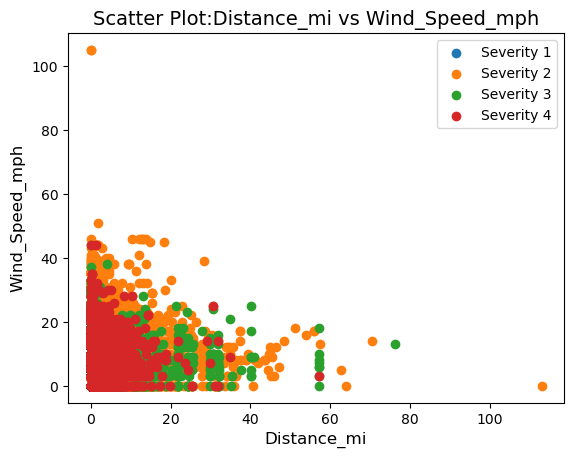

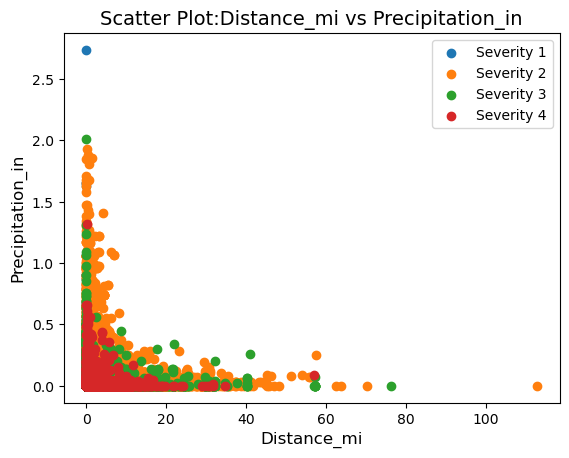

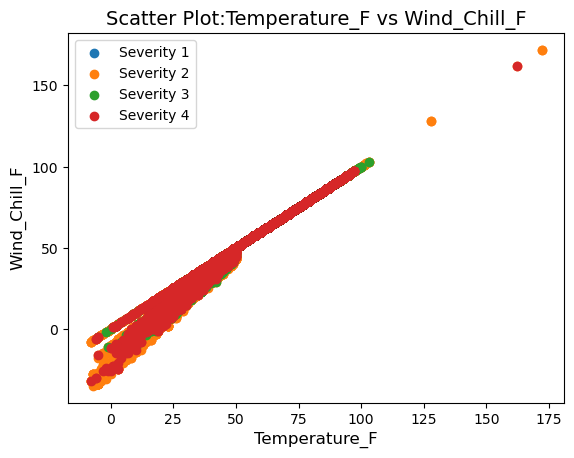

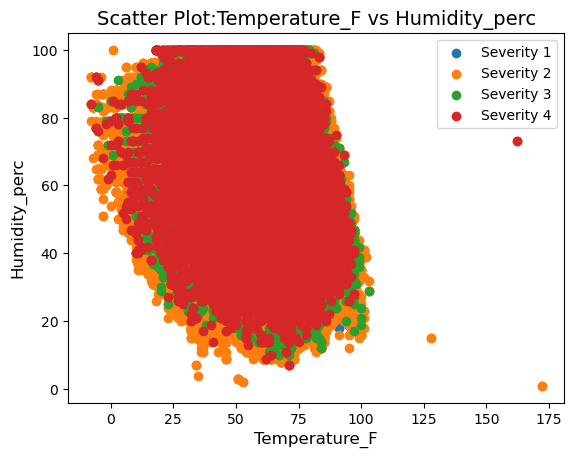

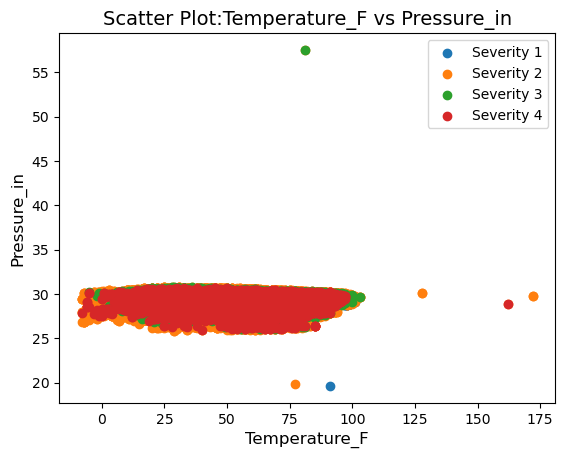

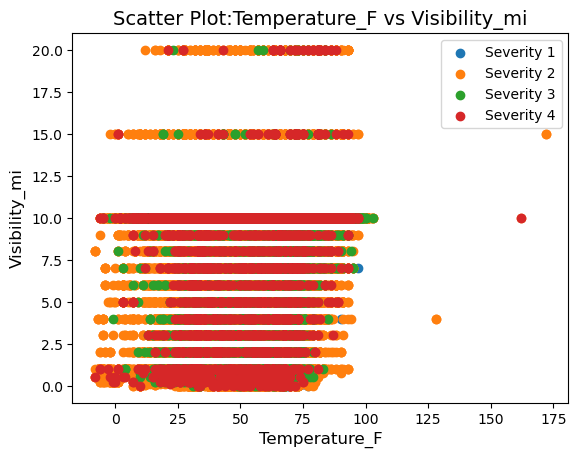

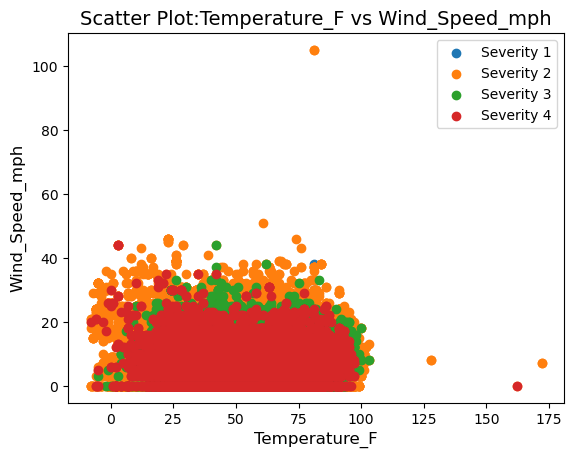

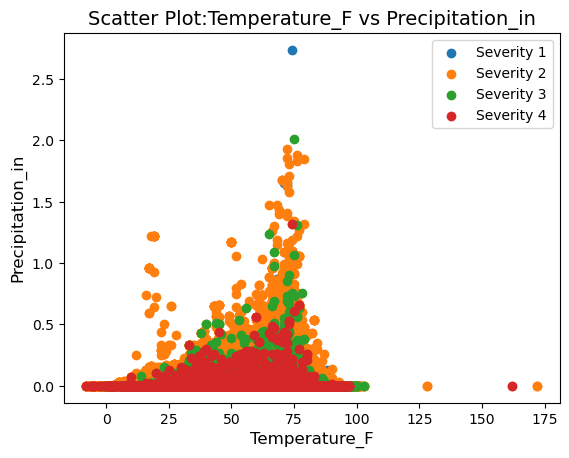

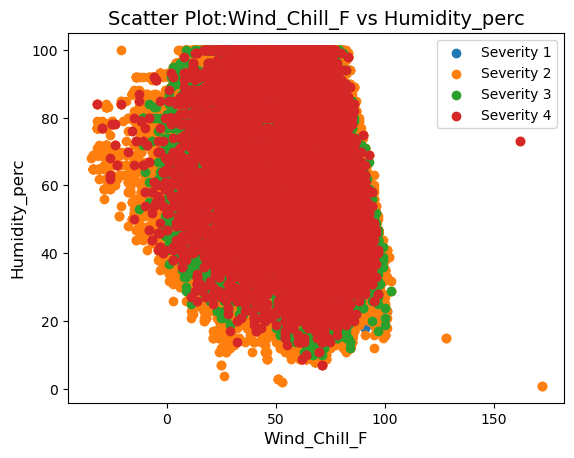

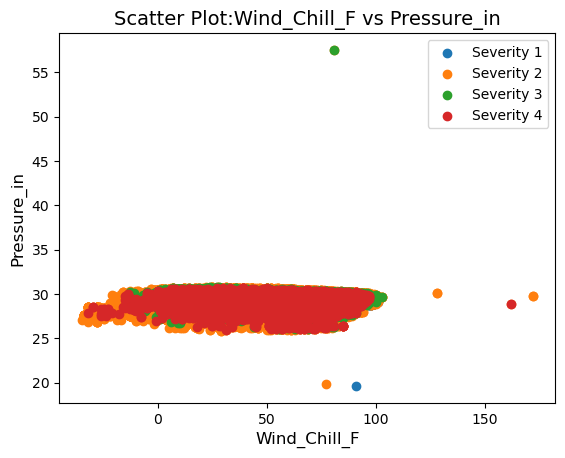

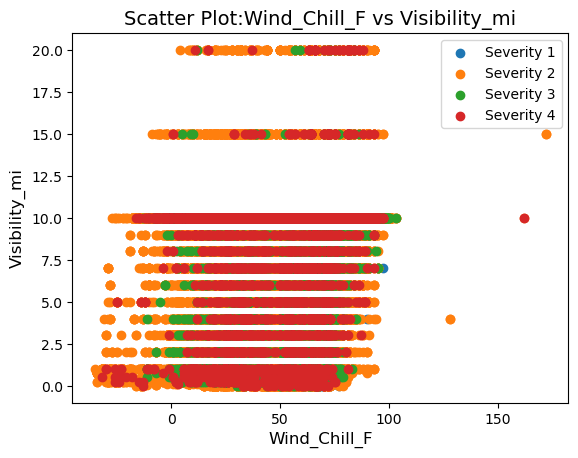

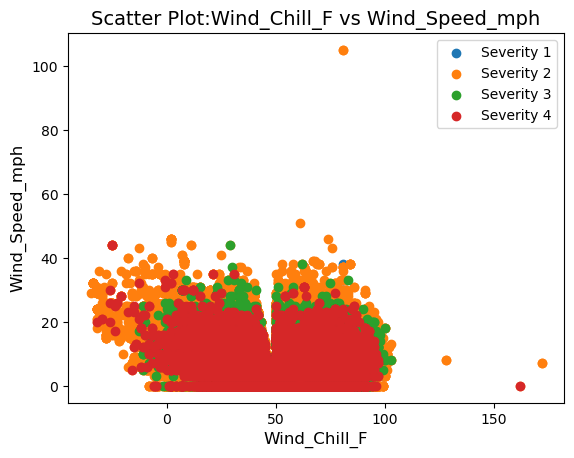

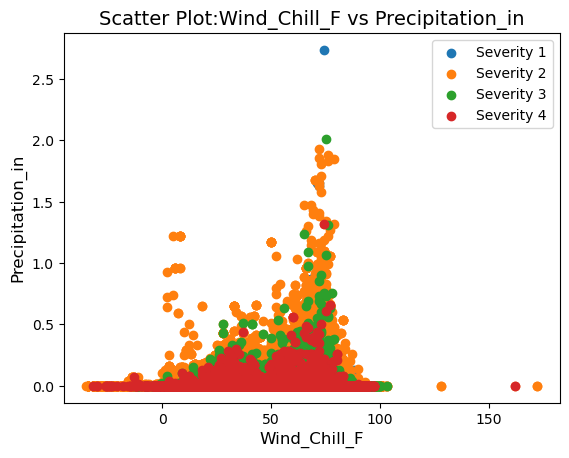

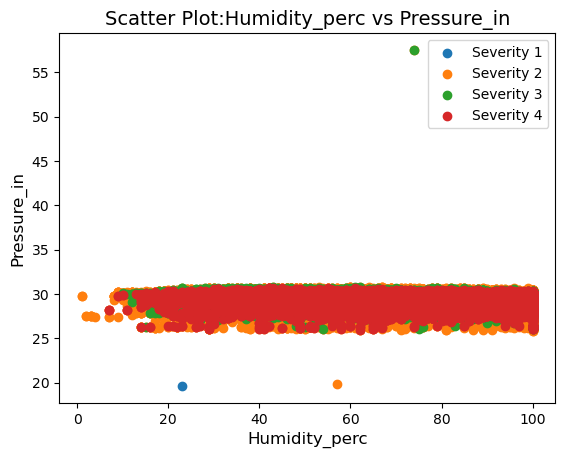

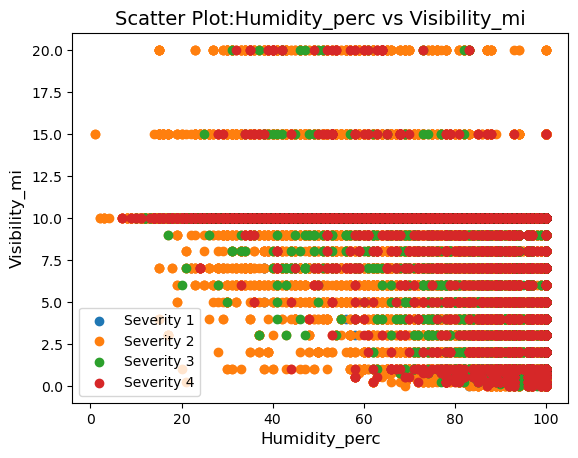

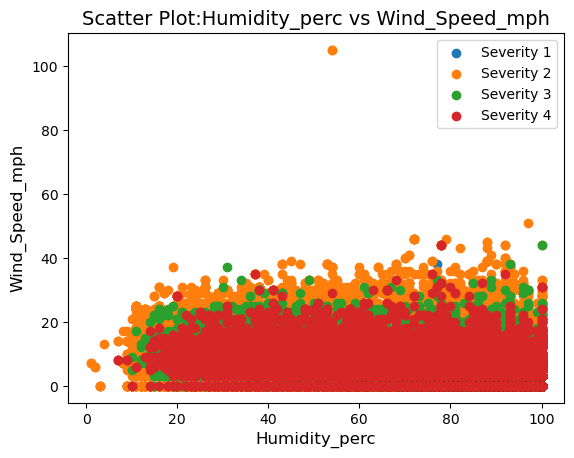

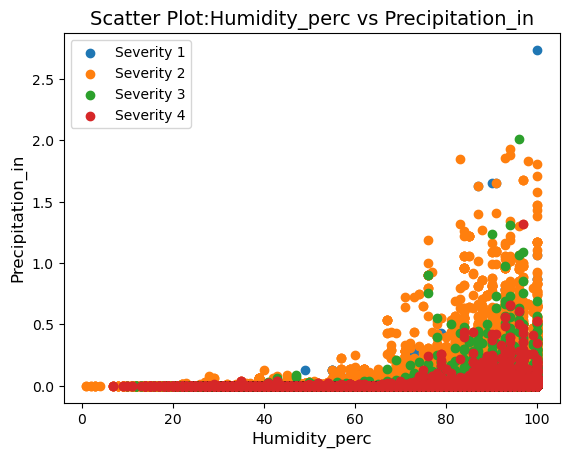

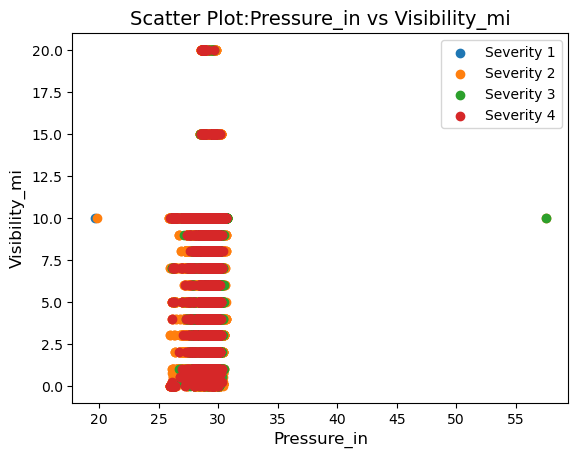

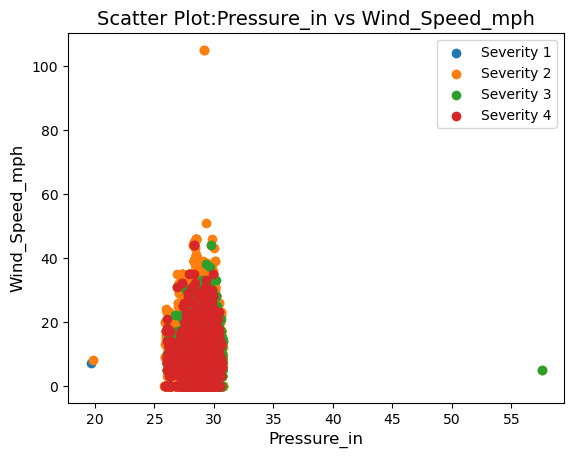

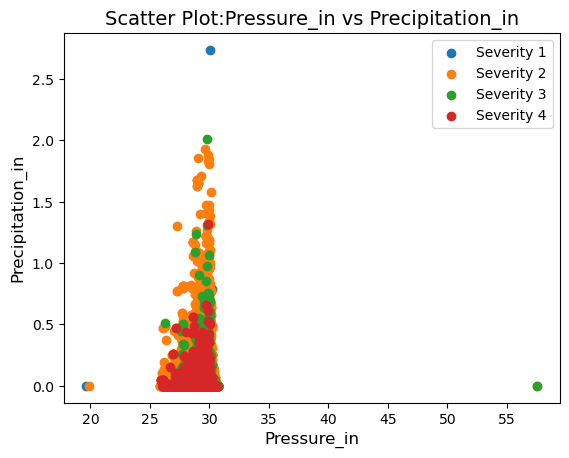

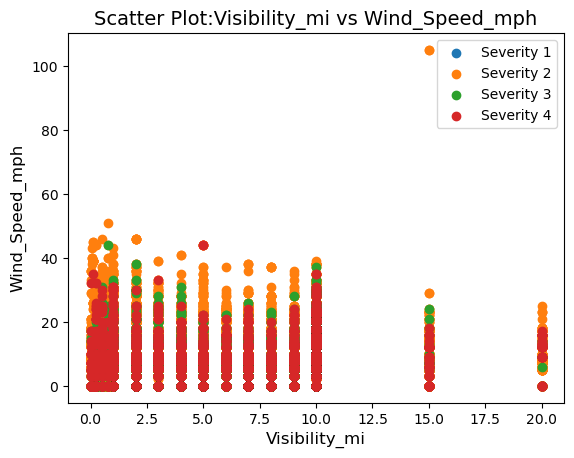

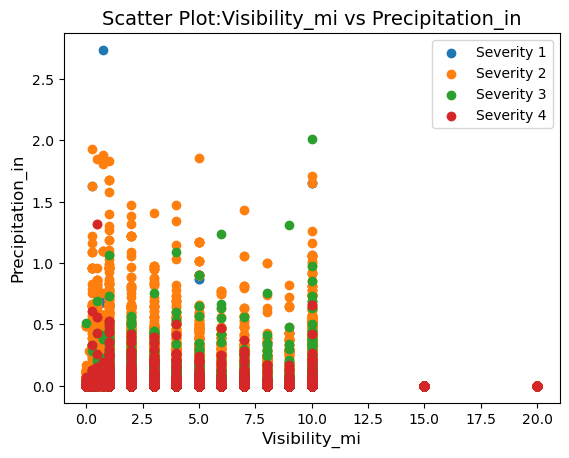

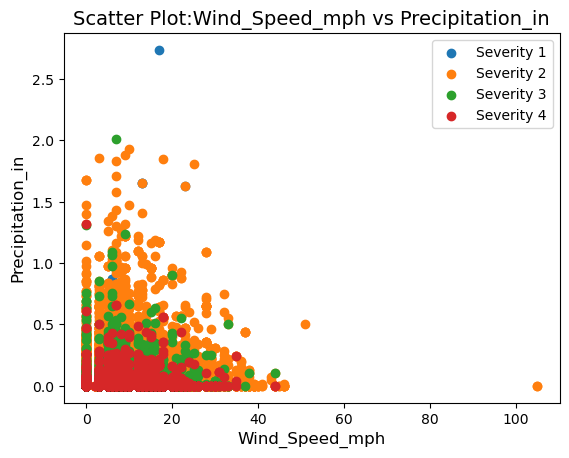

In [23]:
#label severity
i=0
unique_severity =[1,2,3,4]
for el1 in continuos_features:
    for el2 in continuos_features[i+1:]:
        for severity_val in unique_severity:
            data = df.filter(df['Severity'] == severity_val).select(el1, el2).dropna().collect()
            x = [row[el1] for row in data]
            y = [row[el2] for row in data]

            plt.scatter(x, y, label=f'Severity {severity_val}')

        plt.xlabel(el1, size=12)
        plt.ylabel(el2, size=12)
        plt.title('Scatter Plot:'+el1+ ' vs '+ el2, size=14)
        plt.legend()
        plt.show()
    i+=1

Delete record with Pressure_in < 25 or > 31 values

In [3]:
# Counts of records to remove for pressure_in
pres_remove = df.filter((col("Pressure(in)") < 25) | (col("Pressure(in)") > 31)).count()

# Delete records with  pressure_in < 25 and > 31 values
df = df.filter((col("Pressure(in)") >= 25) & (col("Pressure(in)") <= 31))

print(f'{pres_remove} records deleted from Pressure')

4 records deleted from Pressure


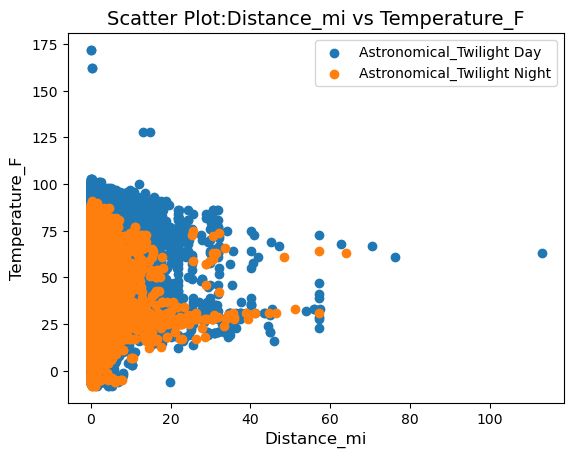

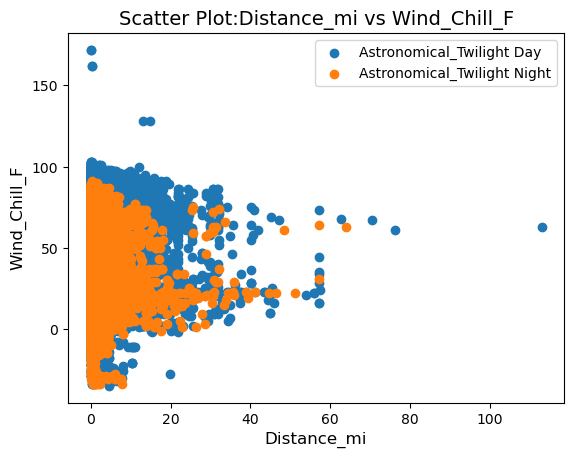

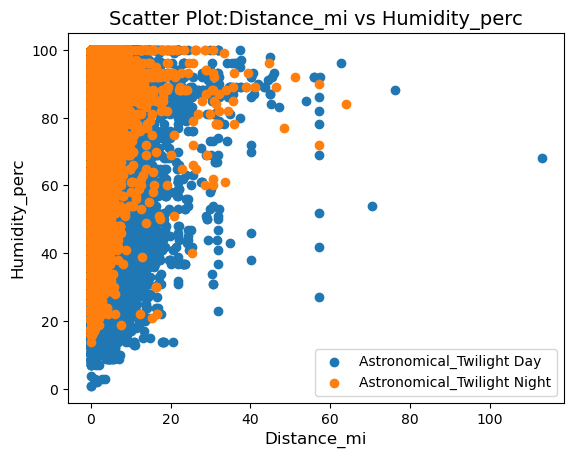

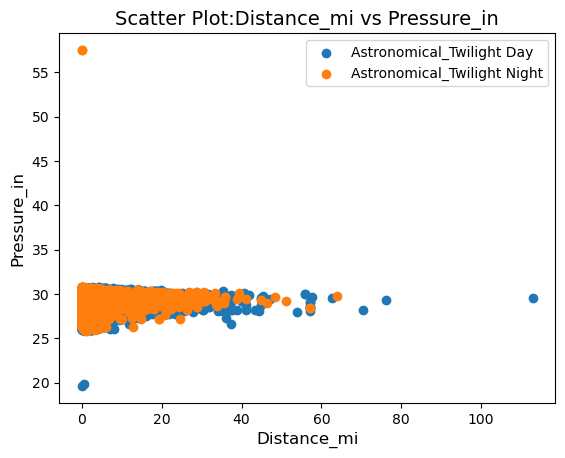

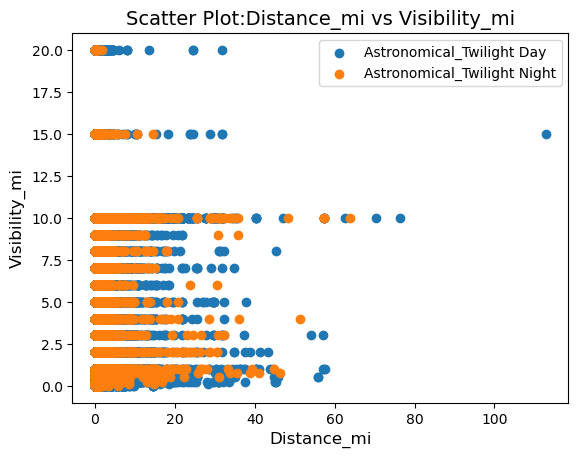

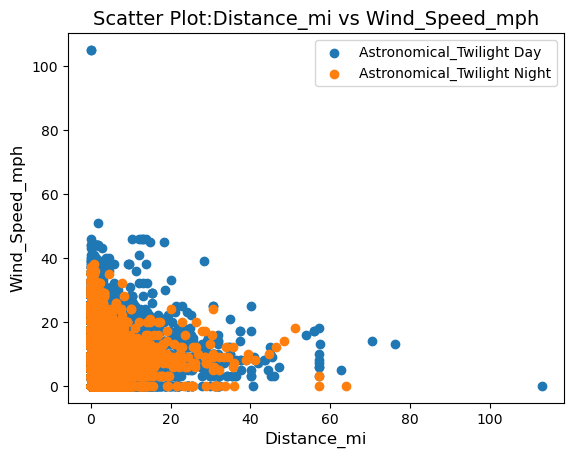

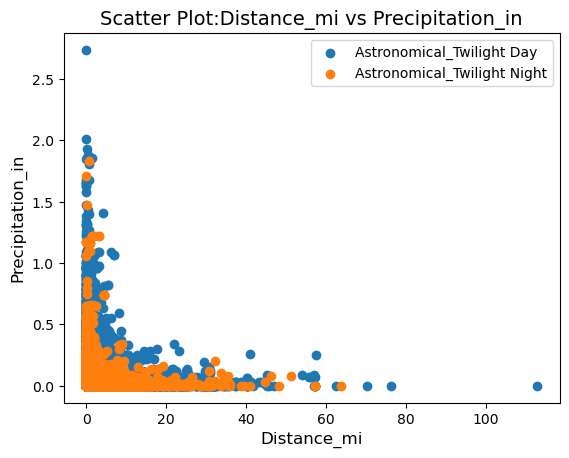

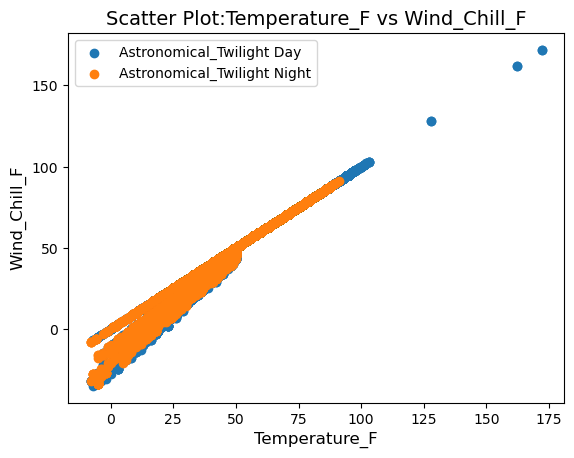

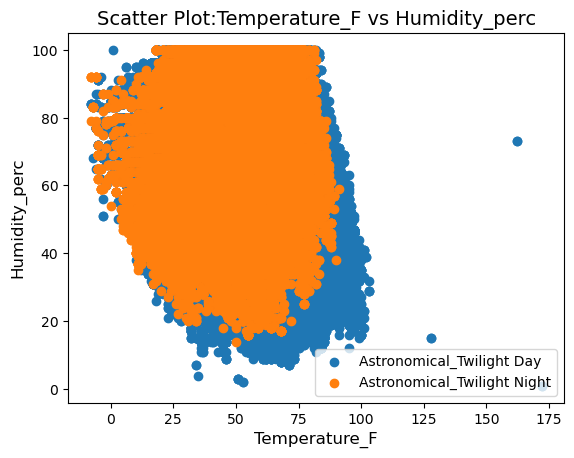

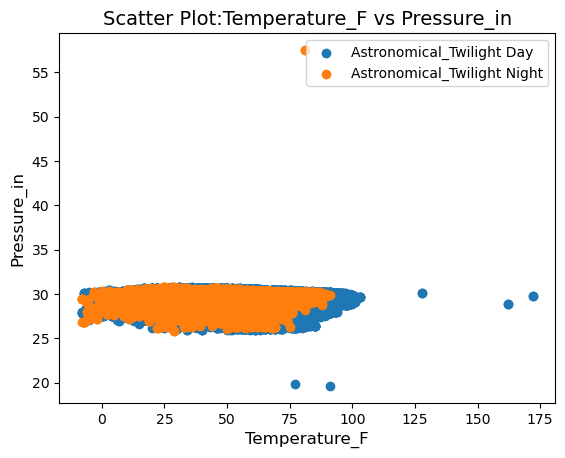

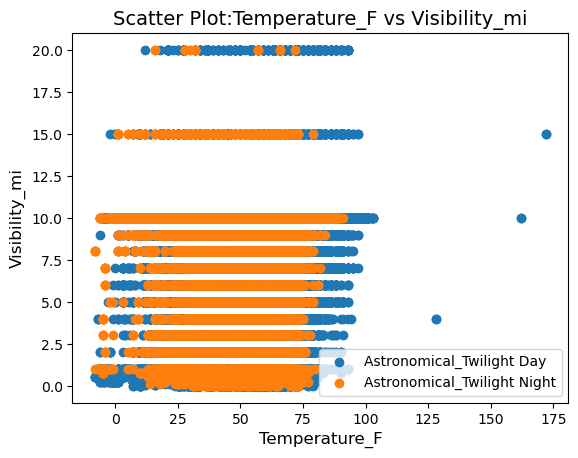

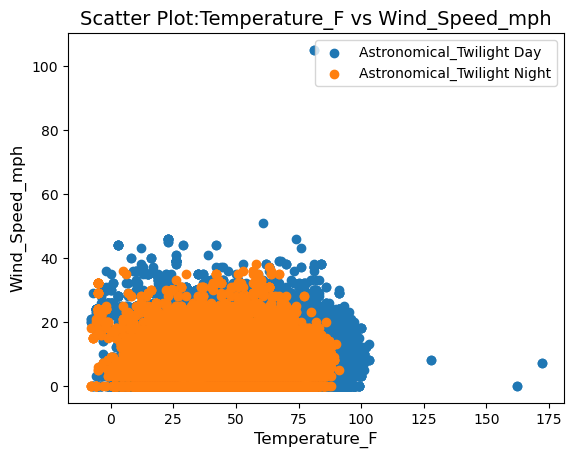

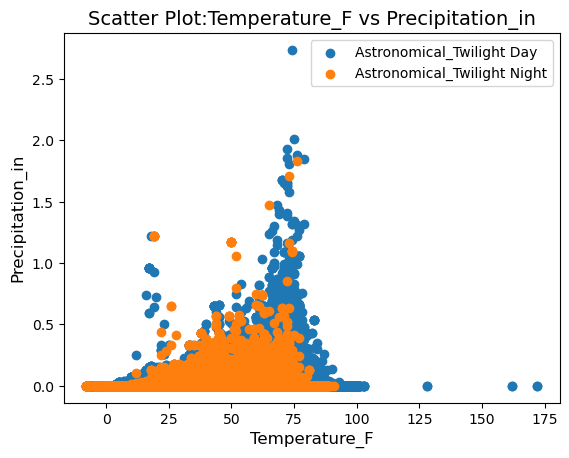

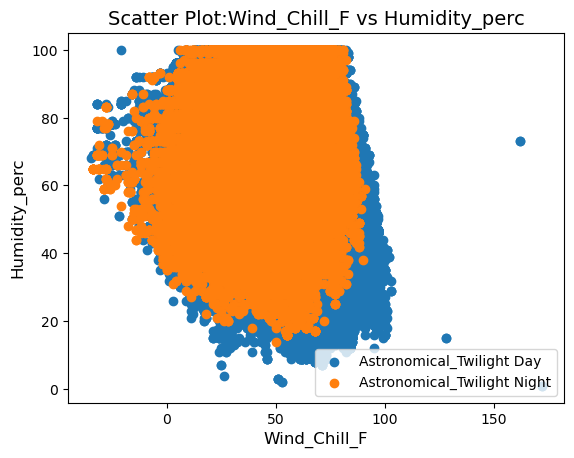

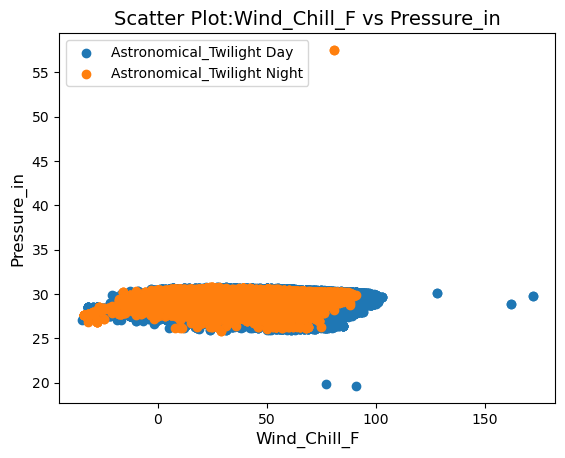

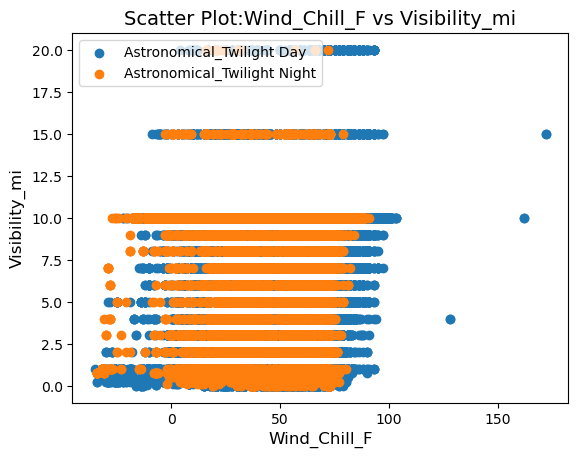

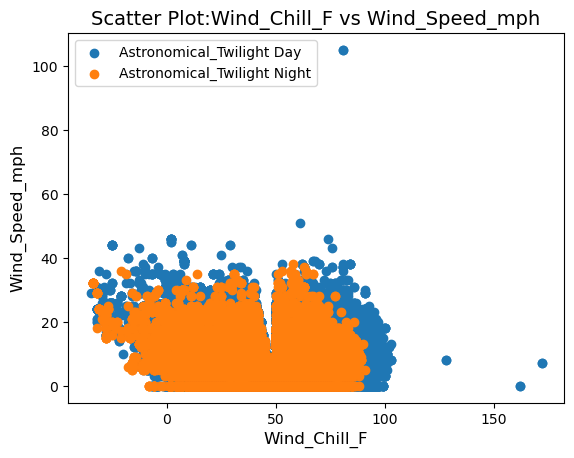

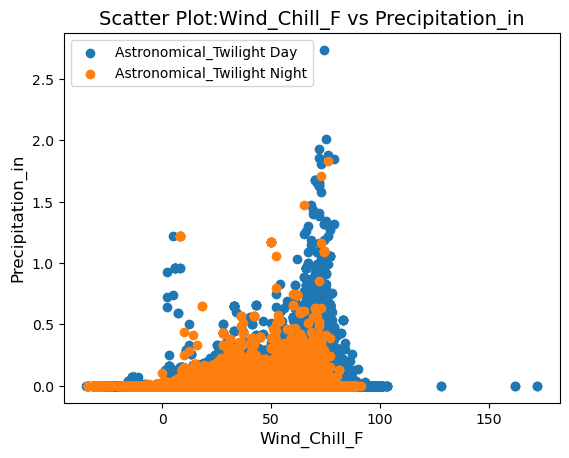

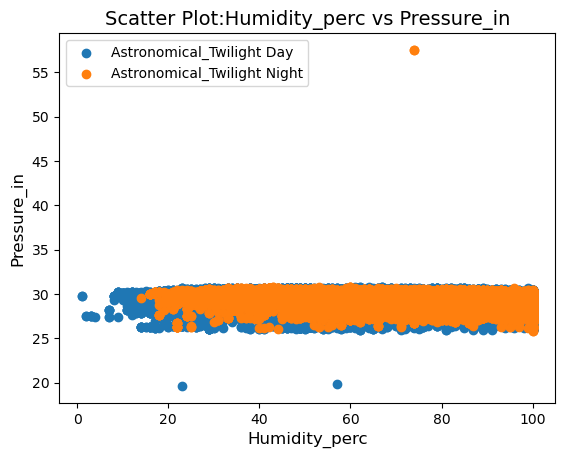

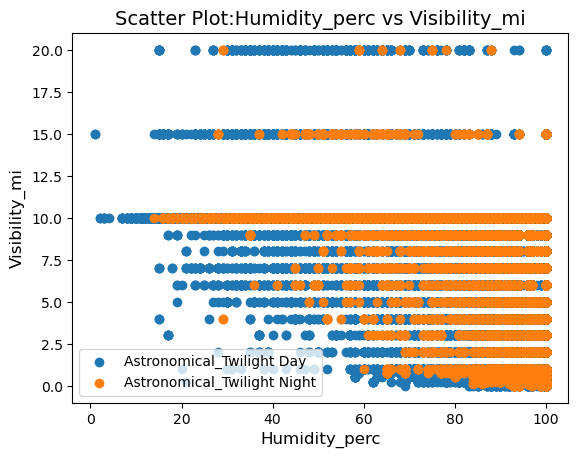

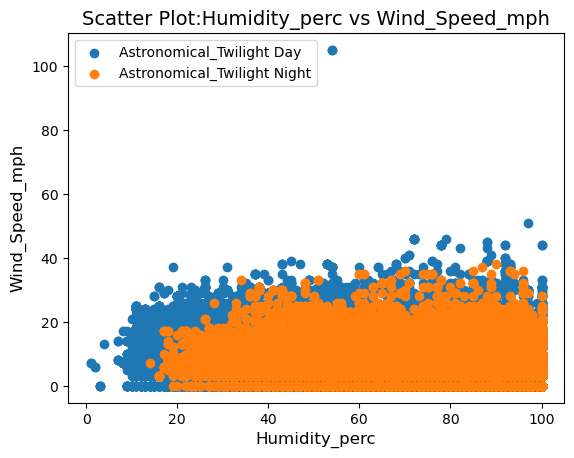

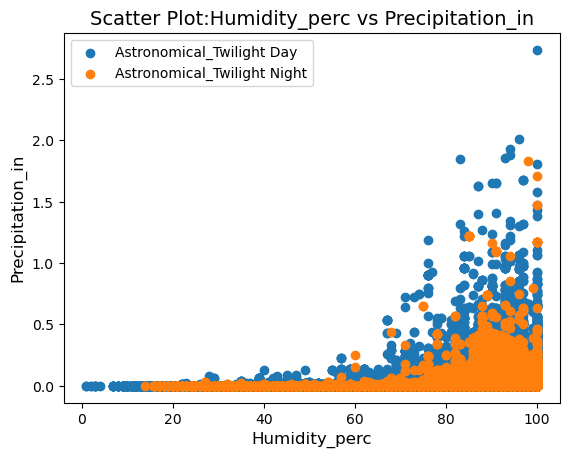

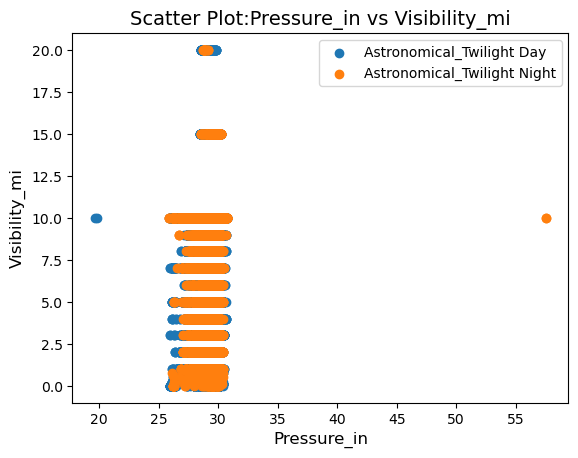

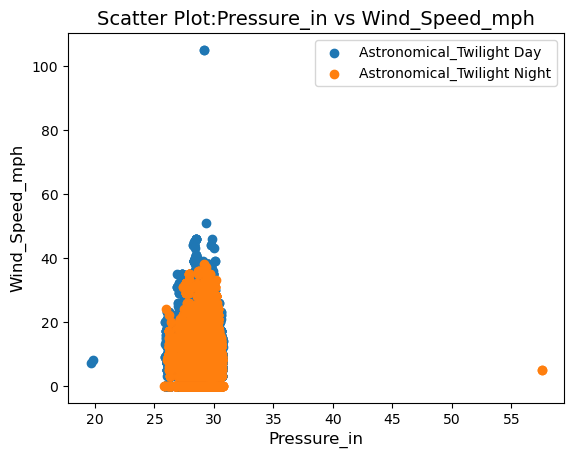

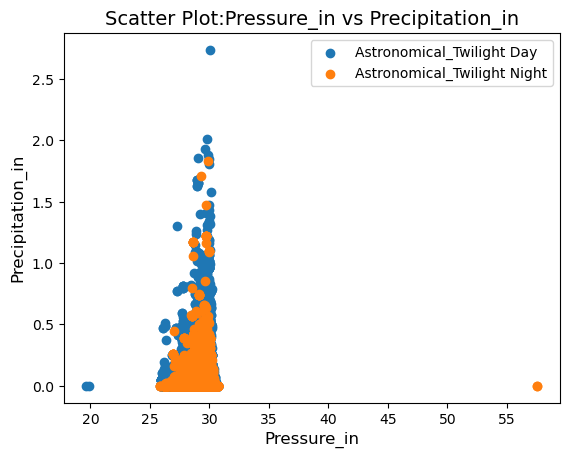

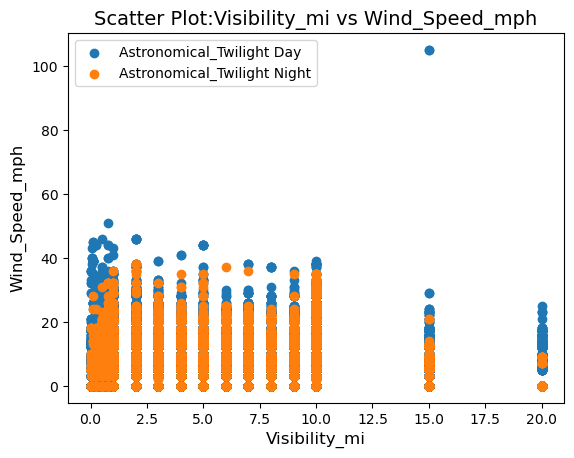

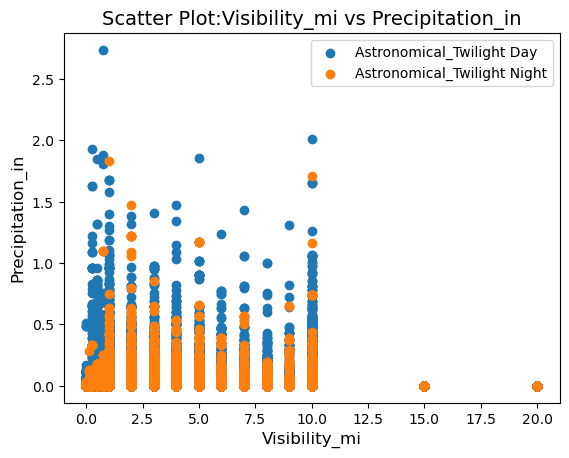

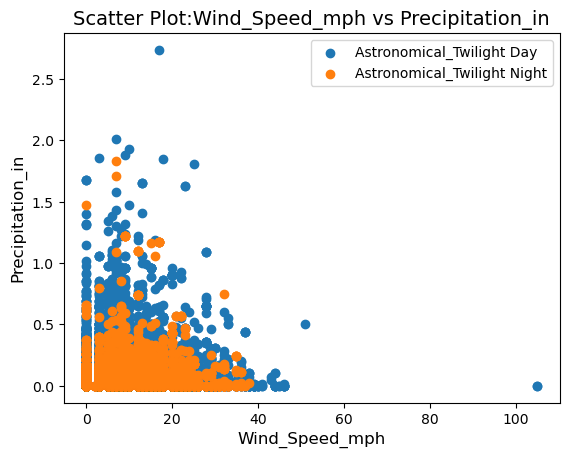

In [24]:
#Scatter con label astronomical_twilight
unique_twilight =['Day','Night']
i=0
for el1 in continuos_features:
    for el2 in continuos_features[i+1:]:
        for twilight_val in unique_twilight:
            data = df.filter(df['Astronomical_Twilight'] == twilight_val).select(el1, el2).dropna().collect()
            x = [row[el1] for row in data]
            y = [row[el2] for row in data]

            plt.scatter(x, y, label=f'Astronomical_Twilight {twilight_val}')

        plt.xlabel(el1, size=12)
        plt.ylabel(el2, size=12)
        plt.title('Scatter Plot:'+el1+ ' vs '+ el2, size=14)
        plt.legend()
        plt.show()
    i+=1

# MISSING VALUES

FILL CITY

In [26]:
#                                               ***** FILLING CITY *****
df.createOrReplaceTempView("missingCity")
query = spark.sql(f'SELECT City,Start_Lat,Start_Lng FROM missingCity m WHERE m.City IS NULL') 
query.show()

+----+---------+----------+
|City|Start_Lat| Start_Lng|
+----+---------+----------+
|NULL|41.036763|-73.675481|
+----+---------+----------+



In [27]:
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull('City'), 'City')).alias('City')])
#missing.toPandas().T
missing.show()

+----+
|City|
+----+
|   1|
+----+



In [29]:
from pyspark.sql.functions import when, lit, col


df = df.withColumn(
    "City",
    when(
        col("City").isNull(),
        lit("Greenwich")  
    ).otherwise(col("City"))
)

In [59]:
df=df.drop('Pressure_in')

FILL Astronomical_Twilight

In [30]:
#                                               ***** FILLING ASTRONOMICAL TWILIGHT *****
from datetime import datetime

# This is the main function to fill the missing values for the feature Astonomical Twilight
def get_day_night_season(date, season, standard_astro):

    hour = date.hour
    
    if standard_astro is None:

        if season == 'Spring':
            return 'Day' if 6 <= hour <= 19 else 'Night'
        elif season == 'Summer':
            return 'Day' if 5 <= hour <= 21 else 'Night'
        elif season == 'Autumn':
            return 'Day' if 6 <= hour <= 18 else 'Night'
        else:
            return 'Day' if 7 <= hour <= 17 else 'Night'
    else:
        return standard_astro

# Registering this new function as a udf, like previously
get_day_night_season_udf = udf(get_day_night_season, StringType())

df = df.withColumn("Astronomical_Twilight_new", get_day_night_season_udf(col('Start_Time'),col('season'),col("Astronomical_Twilight"))) # add the new feature

# Drop old Astronomical_Twilight feature and rename the feature Astronomical_Astro_new just created; then check 
df=df.drop('Astronomical_Twilight') 
df=df.withColumnRenamed("Astronomical_Twilight_new", "Astronomical_Twilight") 
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+--------+----------+---------+---------+-----------+----+------+-----+-------------+------------+-------------+-----------+-------------+--------------+--------------+----------------+-----------------+-------+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+---------------+----+------+---------------+---------------------+
|Severity|Start_Time|Start_Lat|Start_Lng|Distance_mi|City|County|State|Temperature_F|Wind_Chill_F|Humidity_perc|Pressure_in|Visibility_mi|Wind_Direction|Wind_Speed_mph|Precipitation_in|Weather_Condition|Amenity|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|month|day_of_the_week|hour|season|Working_Weekend|Astronomical_Twilight|
+--------+----------+---------+---------+-----------+----+------+-----+-------------+------------+-------------+-----------+-------------+--------------+--------------+----------------+-----------------+-------+--------+--------+-------

Filling Weather_Condition


In [31]:
#                                               ***** FILLING WEATHER CONDITION *****

import pyspark.sql.functions as F
from pyspark.sql import Window

window = Window.partitionBy(["City","month"]).orderBy("City", "month")
tmpdf = df.withColumn("mode", F.mode("Weather_Condition").over(window))
tmpdf2 = tmpdf.withColumn("Weather_Condition", 
                         F.when(F.col("Weather_Condition").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Weather_Condition")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Weather_Condition"), "Weather_Condition")).alias("Weather_Condition")])
missing.toPandas().T


0
Weather_Condition  3101

In [32]:
window = Window.partitionBy(["County","month"]).orderBy("County", "month")
tmpdf = df.withColumn("mode", F.mode("Weather_Condition").over(window))
tmpdf2 = tmpdf.withColumn("Weather_Condition", 
                         F.when(F.col("Weather_Condition").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Weather_Condition")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Weather_Condition"), "Weather_Condition")).alias("Weather_Condition")])
missing.toPandas().T

0
Weather_Condition  127

In [33]:
window = Window.partitionBy(["State","month"]).orderBy("State", "month")
tmpdf = df.withColumn("mode", F.mode("Weather_Condition").over(window))
tmpdf2 = tmpdf.withColumn("Weather_Condition", 
                         F.when(F.col("Weather_Condition").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Weather_Condition")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Weather_Condition"), "Weather_Condition")).alias("Weather_Condition")])
missing.toPandas().T

0
Weather_Condition  0

In [34]:
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+--------+----------+---------+---------+-----------+----+------+-----+-------------+------------+-------------+-----------+-------------+--------------+--------------+----------------+-----------------+-------+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+---------------+----+------+---------------+---------------------+
|Severity|Start_Time|Start_Lat|Start_Lng|Distance_mi|City|County|State|Temperature_F|Wind_Chill_F|Humidity_perc|Pressure_in|Visibility_mi|Wind_Direction|Wind_Speed_mph|Precipitation_in|Weather_Condition|Amenity|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|month|day_of_the_week|hour|season|Working_Weekend|Astronomical_Twilight|
+--------+----------+---------+---------+-----------+----+------+-----+-------------+------------+-------------+-----------+-------------+--------------+--------------+----------------+-----------------+-------+--------+--------+-------

Filling Temperature_F

In [35]:
window = Window.partitionBy(["County", "Astronomical_Twilight","season"]).orderBy("County", "Astronomical_Twilight","season")
tmpdf = df.withColumn("avg", F.avg("Temperature_F").over(window))
tmpdf2 = tmpdf.withColumn("Temperature_F", 
                         F.when(F.col("Temperature_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Temperature_F")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Temperature_F"), "Temperature_F")).alias("Temperature_F")])
missing.toPandas().T

0
Temperature_F  475

In [36]:
window = Window.partitionBy(["State", "Astronomical_Twilight","season"]).orderBy("State", "Astronomical_Twilight","season")
tmpdf = df.withColumn("avg", F.avg("Temperature_F").over(window))
tmpdf2 = tmpdf.withColumn("Temperature_F", 
                         F.when(F.col("Temperature_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Temperature_F")))
tmpdf3 = tmpdf2.drop("avg")
df = tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Temperature_F"), "Temperature_F")).alias("Temperature_F")])
missing.toPandas().T

0
Temperature_F  0

Filling Wind_Chill_F

In [37]:
window = Window.partitionBy(["County","season","Astronomical_Twilight"]).orderBy("County","season", "Astronomical_Twilight")
tmpdf = df.withColumn("avg", F.avg("Wind_Chill_F").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Chill_F", 
                         F.when(F.col("Wind_Chill_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Chill_F")))
tmpdf3 = tmpdf2.drop("avg")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Chill_F"), "Wind_Chill_F")).alias("Wind_Chill_F")])
missing.toPandas().T

0
Wind_Chill_F  498

In [38]:
window = Window.partitionBy(["State","season", "Astronomical_Twilight"]).orderBy("State", "season", "Astronomical_Twilight")
tmpdf = df.withColumn("avg", F.avg("Wind_Chill_F").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Chill_F", 
                         F.when(F.col("Wind_Chill_F").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Chill_F")))
tmpdf3 = tmpdf2.drop("avg")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Chill_F"), "Wind_Chill_F")).alias("Wind_Chill_F")])
missing.toPandas().T

0
Wind_Chill_F  0

Filling Humidity_perc

In [39]:
window = Window.partitionBy(["County", "Astronomical_Twilight","season"]).orderBy("County", "Astronomical_Twilight","season")
tmpdf = df.withColumn("avg", F.avg("Humidity_perc").over(window))
tmpdf2 = tmpdf.withColumn("Humidity_perc", 
                         F.when(F.col("Humidity_perc").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Humidity_perc")))
tmpdf3 = tmpdf2.drop("avg")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Humidity_perc"), "Humidity_perc")).alias("Humidity_perc")])
missing.toPandas().T

0
Humidity_perc  475

In [40]:
window = Window.partitionBy(["State", "Astronomical_Twilight","season"]).orderBy("County","season")
tmpdf = df.withColumn("avg", F.avg("Humidity_perc").over(window))
tmpdf2 = tmpdf.withColumn("Humidity_perc", 
                         F.when(F.col("Humidity_perc").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Humidity_perc")))
tmpdf3 = tmpdf2.drop("avg")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Humidity_perc"), "Humidity_perc")).alias("Humidity_perc")])
missing.toPandas().T


0
Humidity_perc  0

Filling Wind_Direction

In [41]:
window = Window.partitionBy(["County", "Wind_Chill_F","season"]).orderBy("County", "Wind_Chill_F","season")
tmpdf = df.withColumn("mode", F.mode("Wind_Direction").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Direction", 
                         F.when(F.col("Wind_Direction").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Wind_Direction")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Direction"), "Wind_Direction")).alias("Wind_Direction")])
missing.toPandas().T

0
Wind_Direction  9297

In [42]:
window = Window.partitionBy(["State", "Wind_Chill_F","season"]).orderBy("State", "Wind_Chill_F","season")
tmpdf = df.withColumn("mode", F.mode("Wind_Direction").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Direction", 
                         F.when(F.col("Wind_Direction").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Wind_Direction")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Direction"), "Wind_Direction")).alias("Wind_Direction")])
missing.toPandas().T

0
Wind_Direction  8897

In [43]:
window = Window.partitionBy(["City", "Wind_Chill_F","season"]).orderBy("State", "Wind_Chill_F","season")
tmpdf = df.withColumn("mode", F.mode("Wind_Direction").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Direction", 
                         F.when(F.col("Wind_Direction").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Wind_Direction")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Direction"), "Wind_Direction")).alias("Wind_Direction")])
missing.toPandas().T

0
Wind_Direction  8897

In [44]:
window = Window.partitionBy(['County',"season"]).orderBy("State", "Wind_Chill_F","season")
tmpdf = df.withColumn("mode", F.mode("Wind_Direction").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Direction", 
                         F.when(F.col("Wind_Direction").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Wind_Direction")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Direction"), "Wind_Direction")).alias("Wind_Direction")])
missing.toPandas().T

0
Wind_Direction  255

In [45]:
window = Window.partitionBy(['State',"season"]).orderBy("State", "Wind_Chill_F","season")
tmpdf = df.withColumn("mode", F.mode("Wind_Direction").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Direction", 
                         F.when(F.col("Wind_Direction").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Wind_Direction")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Direction"), "Wind_Direction")).alias("Wind_Direction")])
missing.toPandas().T

0
Wind_Direction  0

Filling Wind_Speed_mph

In [46]:

window = Window.partitionBy(["County", "Wind_Chill_F","season"]).orderBy("County", "Wind_Chill_F","season")
tmpdf = df.withColumn("avg", F.mode("Wind_Speed_mph").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Speed_mph", 
                         F.when(F.col("Wind_Speed_mph").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Speed_mph")))
tmpdf3 = tmpdf2.drop("avg")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Speed_mph"), "Wind_Speed_mph")).alias("Wind_Speed_mph")])
missing.toPandas().T

0
Wind_Speed_mph  9297

In [47]:
window = Window.partitionBy(["State", "Wind_Chill_F","season"]).orderBy("State", "Wind_Chill_F","season")
tmpdf = df.withColumn("avg", F.mode("Wind_Speed_mph").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Speed_mph", 
                         F.when(F.col("Wind_Speed_mph").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Speed_mph")))
tmpdf3 = tmpdf2.drop("avg")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Speed_mph"), "Wind_Speed_mph")).alias("Wind_Speed_mph")])
missing.toPandas().T


0
Wind_Speed_mph  8897

In [48]:
window = Window.partitionBy(["County",'season']).orderBy("State", "Wind_Chill_F","season")
tmpdf = df.withColumn("avg", F.mode("Wind_Speed_mph").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Speed_mph", 
                         F.when(F.col("Wind_Speed_mph").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Speed_mph")))
tmpdf3 = tmpdf2.drop("avg")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Speed_mph"), "Wind_Speed_mph")).alias("Wind_Speed_mph")])
missing.toPandas().T

0
Wind_Speed_mph  255

In [49]:
window = Window.partitionBy(["State","season"]).orderBy("State", "Wind_Chill_F","season")
tmpdf = df.withColumn("avg", F.mode("Wind_Speed_mph").over(window))
tmpdf2 = tmpdf.withColumn("Wind_Speed_mph", 
                         F.when(F.col("Wind_Speed_mph").isNull(),
                                F.col("avg"))
                                .otherwise(F.col("Wind_Speed_mph")))
tmpdf3 = tmpdf2.drop("avg")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Wind_Speed_mph"), "Wind_Speed_mph")).alias("Wind_Speed_mph")])
missing.toPandas().T

0
Wind_Speed_mph  0

Filling Precipitation_in

In [50]:
window = Window.partitionBy(["City","month"]).orderBy("City", "month")
tmpdf = df.withColumn("mode", F.mode("Precipitation_in").over(window))
tmpdf2 = tmpdf.withColumn("Precipitation_in", 
                         F.when(F.col("Precipitation_in").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Precipitation_in")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Precipitation_in"), "Precipitation_in")).alias("Precipitation_in")])
missing.toPandas().T

0
Precipitation_in  3256

In [51]:
window = Window.partitionBy(["County","month"]).orderBy("County", "month")
tmpdf = df.withColumn("mode", F.mode("Precipitation_in").over(window))
tmpdf2 = tmpdf.withColumn("Precipitation_in", 
                         F.when(F.col("Precipitation_in").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Precipitation_in")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Precipitation_in"), "Precipitation_in")).alias("Precipitation_in")])
missing.toPandas().T

0
Precipitation_in  221

In [52]:
window = Window.partitionBy(["County","season"]).orderBy("County", "month")
tmpdf = df.withColumn("mode", F.mode("Precipitation_in").over(window))
tmpdf2 = tmpdf.withColumn("Precipitation_in", 
                         F.when(F.col("Precipitation_in").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Precipitation_in")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Precipitation_in"), "Precipitation_in")).alias("Precipitation_in")])
missing.toPandas().T

0
Precipitation_in  139

In [53]:
window = Window.partitionBy(["State","season"]).orderBy("County", "month")
tmpdf = df.withColumn("mode", F.mode("Precipitation_in").over(window))
tmpdf2 = tmpdf.withColumn("Precipitation_in", 
                         F.when(F.col("Precipitation_in").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Precipitation_in")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Precipitation_in"), "Precipitation_in")).alias("Precipitation_in")])
missing.toPandas().T

0
Precipitation_in  0

Filling Visibility_mi

In [54]:
window = Window.partitionBy(["County","season","Astronomical_Twilight"]).orderBy("County","season","Astronomical_Twilight")
tmpdf = df.withColumn("mode", F.mode("Visibility_mi").over(window))
tmpdf2 = tmpdf.withColumn("Visibility_mi", 
                         F.when(F.col("Visibility_mi").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Visibility_mi")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Visibility_mi"), "Visibility_mi")).alias("Visibility_mi")])
missing.toPandas().T

0
Visibility_mi  455

In [55]:
window = Window.partitionBy(["County","season"]).orderBy("County","season")
tmpdf = df.withColumn("mode", F.mode("Visibility_mi").over(window))
tmpdf2 = tmpdf.withColumn("Visibility_mi", 
                         F.when(F.col("Visibility_mi").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Visibility_mi")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Visibility_mi"), "Visibility_mi")).alias("Visibility_mi")])
missing.toPandas().T

0
Visibility_mi  441

In [56]:

window = Window.partitionBy(["County"]).orderBy("County")
tmpdf = df.withColumn("mode", F.mode("Visibility_mi").over(window))
tmpdf2 = tmpdf.withColumn("Visibility_mi", 
                         F.when(F.col("Visibility_mi").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Visibility_mi")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Visibility_mi"), "Visibility_mi")).alias("Visibility_mi")])
missing.toPandas().T


0
Visibility_mi  430

In [57]:
window = Window.partitionBy(["State"]).orderBy("State")
tmpdf = df.withColumn("mode", F.mode("Visibility_mi").over(window))
tmpdf2 = tmpdf.withColumn("Visibility_mi", 
                         F.when(F.col("Visibility_mi").isNull(),
                                F.col("mode"))
                                .otherwise(F.col("Visibility_mi")))
tmpdf3 = tmpdf2.drop("mode")
df=tmpdf3
#Checking missing values
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull("Visibility_mi"), "Visibility_mi")).alias("Visibility_mi")])
missing.toPandas().T

0
Visibility_mi  0

Check if all features are filled correctly

In [60]:
from pyspark.sql.functions import when, count, isnull
missing = df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+--------+----------+---------+---------+-----------+----+------+-----+-------------+------------+-------------+-------------+--------------+--------------+----------------+-----------------+-------+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+-----+---------------+----+------+---------------+---------------------+
|Severity|Start_Time|Start_Lat|Start_Lng|Distance_mi|City|County|State|Temperature_F|Wind_Chill_F|Humidity_perc|Visibility_mi|Wind_Direction|Wind_Speed_mph|Precipitation_in|Weather_Condition|Amenity|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|month|day_of_the_week|hour|season|Working_Weekend|Astronomical_Twilight|
+--------+----------+---------+---------+-----------+----+------+-----+-------------+------------+-------------+-------------+--------------+--------------+----------------+-----------------+-------+--------+--------+--------+-------+-------+----------+-------

Check duplicates and delete them

In [61]:
rows = df.count()
cols = len(df.columns)
print(f'Il Dataset contiene {rows} records con duplicati')
print('\n')
df = df.distinct()
rows2 = df.count()
print(f'Il Dataset contiene {rows2} record distinti')

Il Dataset contiene 431962 records con duplicati




23/12/15 19:36:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 19:36:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 19:36:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 19:36:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 19:36:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 19:36:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 19:36:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 19:36:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/12/15 19:36:34 WARN RowBasedKeyValueBatch: Calling spill() on

Il Dataset contiene 394519 record distinti


# READ THE CLEANED DATASET AND PERFORM OUTLIER DETECTION

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
from pyspark.mllib.stat import Statistics
from pyspark.sql.types import IntegerType, DoubleType, BooleanType, StringType, TimestampType


from pyspark.ml.feature import VectorAssembler,StandardScaler

spark = SparkSession.Builder().appName('DDAM_Project_East').getOrCreate()
sqlCtx = SQLContext(spark)
df = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('../../Datasets/East_Incidents_Cleaned.csv')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/18 16:40:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/opt/anaconda3/lib/python3.9/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
df.count()

394519

In [4]:
df.show()

+--------+-------------------+------------------+------------------+-----------+---------+---------+-----+-------------+-------------+-------------+--------------+--------------+----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+-----+---------------+----+------+---------------+---------------------+
|Severity|         Start_Time|         Start_Lat|         Start_Lng|Distance_mi|     City|   County|State|Temperature_F|Humidity_perc|Visibility_mi|Wind_Direction|Wind_Speed_mph|Precipitation_in|Weather_Condition|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|month|day_of_the_week|hour|season|Working_Weekend|Astronomical_Twilight|
+--------+-------------------+------------------+------------------+-----------+---------+---------+-----+-------------+-------------+-------------+--------------+--------------+----------------+-------

23/12/15 19:38:14 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Delete records with temperature > 130

In [3]:
# Counts of records to remove for temperature
temp_remove = df.filter(col("Temperature_F") > 130).count()

# Delete records with temperature > 130 values
df = df.filter(col("Temperature_F") <= 130)

print(f'{temp_remove} records removed for Temperature')

3 records removed for Temperature


BOXPLOTS

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=20593Kb max_used=20728Kb free=110478Kb
 bounds [0x00000001089d8000, 0x0000000109e38000, 0x00000001109d8000]
 total_blobs=8231 nmethods=7323 adapters=821
 compilation: disabled (not enough contiguous free space left)


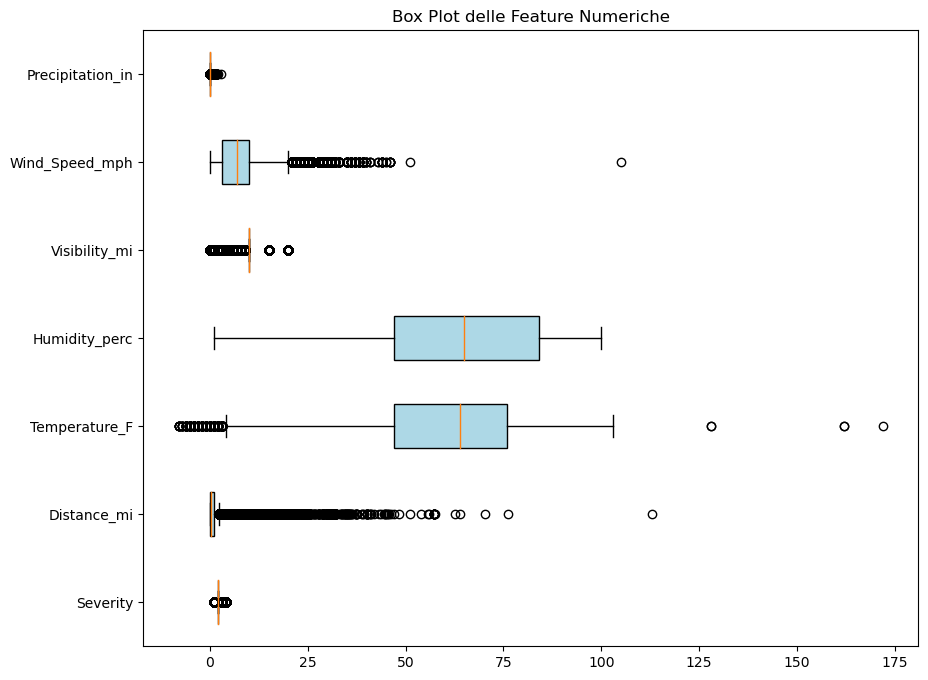

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

numerical_features = ['Severity', 'Distance_mi', 'Temperature_F','Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
df_numerical = df.select(numerical_features).na.drop()
df_numerical_pd = df_numerical.toPandas()
plt.figure(figsize=(10, 8))
plt.boxplot(df_numerical_pd.values, vert=False, labels=numerical_features, patch_artist=True, boxprops=dict(facecolor="lightblue"))

plt.title("Box Plot delle Feature Numeriche")
plt.show()


Pearson and Spearman correlation

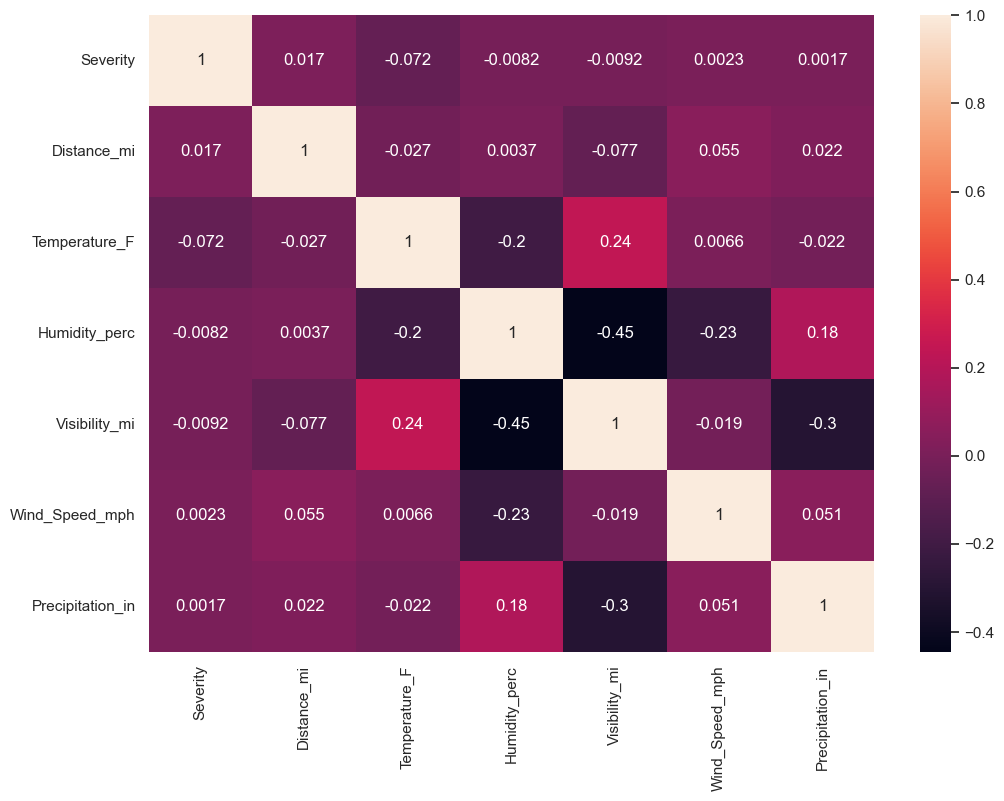

In [4]:
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import corr

numerical_features = ['Severity', 'Distance_mi', 'Temperature_F','Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
correlationDF = df.select(numerical_features).toPandas().corr()
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.heatmap(correlationDF, annot=True)
plt.show()


In [4]:
cols=['Distance_mi', 'Temperature_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']

23/12/16 20:47:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


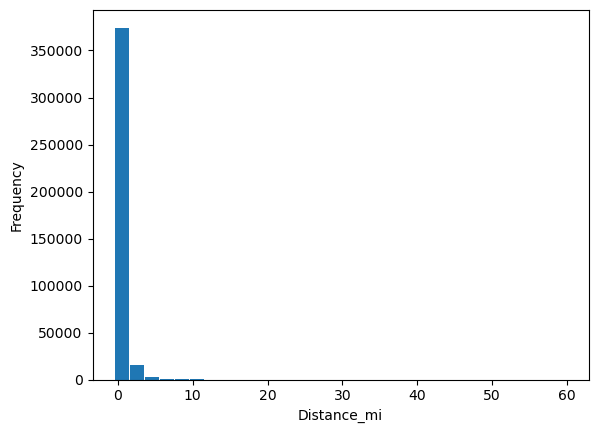

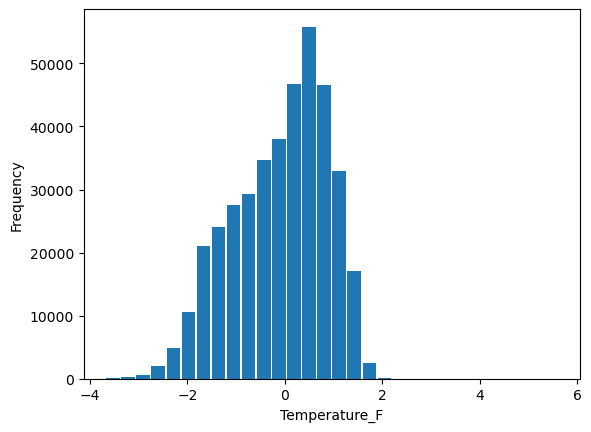

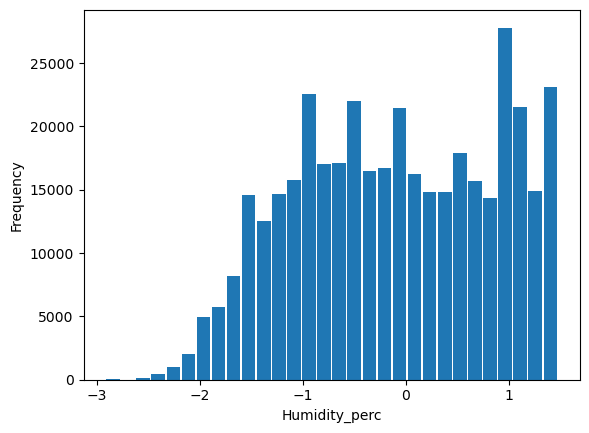

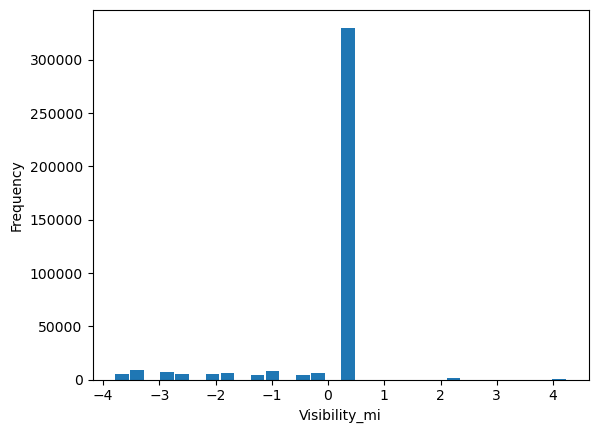

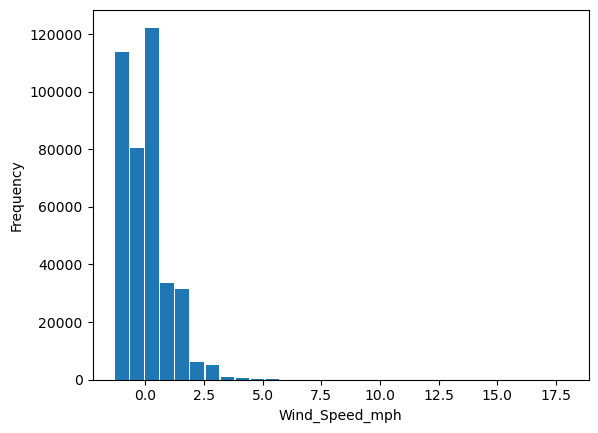

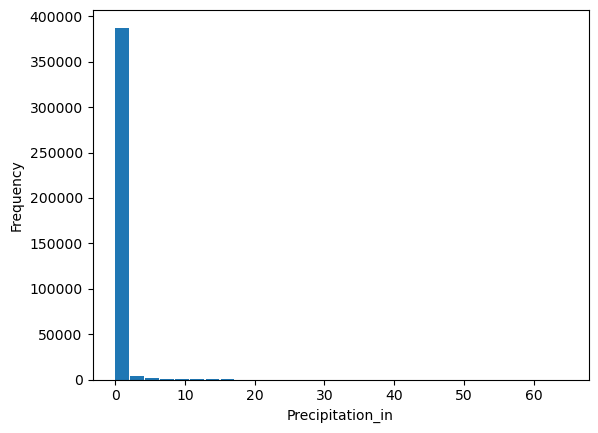

In [5]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(inputCols=cols, outputCol="features")
assembled_df = assembler.transform(df)
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
# Calcola la media e la deviazione standard
scaler_model = scaler.fit(assembled_df)
# Applica lo StandardScaler al DataFrame
scaled_df = scaler_model.transform(assembled_df)
scaled_df.createOrReplaceTempView("Incidents_Data")
query = spark.sql('SELECT scaled_features FROM Incidents_Data') 
i=0
for col in cols:
    h = query.select('scaled_features').rdd.map(lambda x: x[0][i]).histogram(30)
    dfh = pd.DataFrame(
        list(zip(*h)), 
        columns=['bin', 'frequency']
    )
    # estraggo dai dal dataframe pandas per ottenere i bin e le frequenze necessari per il plotting
    bins = dfh['bin']
    counts = dfh['frequency']
    #  classic pandas syntax
    plt.hist(bins, len(bins), weights=counts, rwidth=0.9)
    plt.xlabel(f'{col}', size=10)
    plt.ylabel("Frequency", size=10)
    #plt.grid(True) 
    plt.show()
    i+=1

conta outliers

In [6]:
scaled_df.createOrReplaceTempView("outliers") 
query = sqlCtx.sql("Select scaled_features from outliers o")
#query.show()
i=0
xy_columns = ['Distance_mi', 'Temperature_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
range_=[(-1,7),(-3,2),(-2.5,1.5),(-4,1),(-2,5),(-1,15)]
i=0
for col in xy_columns: 
    h = query.select('scaled_features').rdd.map(lambda x: x[0][i])
    even_numbers = h.filter(lambda x: x>range_[i][1] or x<range_[i][0])
    print(even_numbers.count(),'è la colonna',col)
    i+=1

960 è la colonna Distance_mi


609 è la colonna Temperature_F


18347 è la colonna Humidity_perc


1661 è la colonna Visibility_mi


133 è la colonna Wind_Speed_mph


314 è la colonna Precipitation_in


BOXPLOTS 2

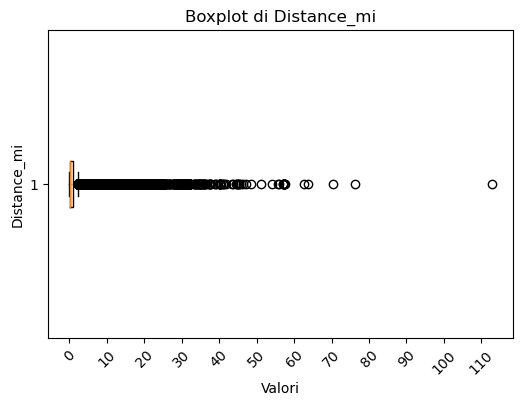

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=38396Kb max_used=38481Kb free=92675Kb
 bounds [0x00000001089d8000, 0x000000010afb8000, 0x00000001109d8000]
 total_blobs=14918 nmethods=13922 adapters=907
 compilation: disabled (not enough contiguous free space left)


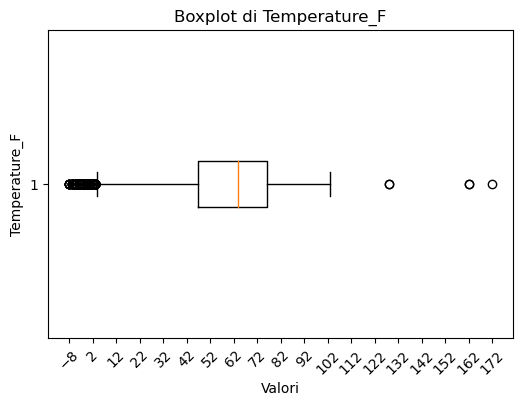

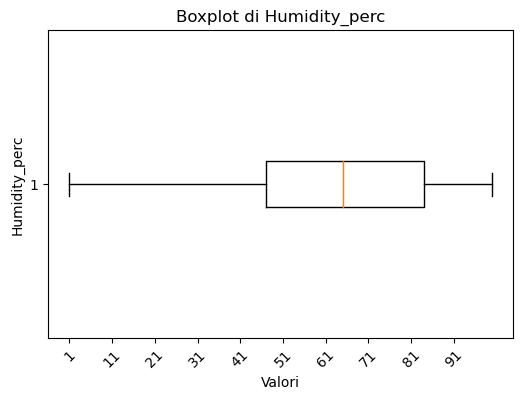

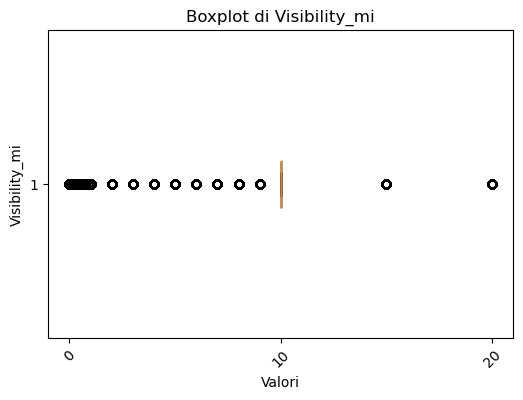

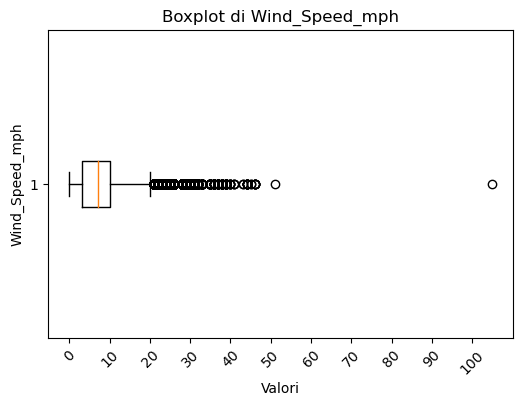

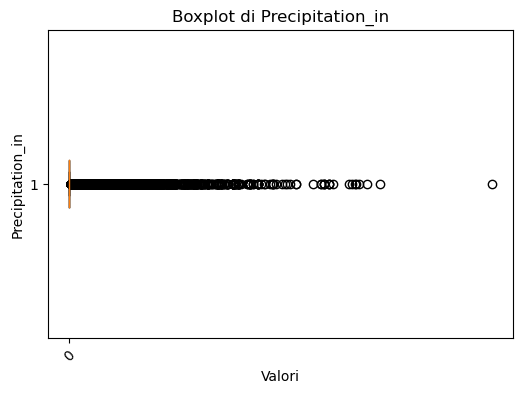

[['Numero outlier per Distance_mi 42130'], ['Numero outlier per Temperature_F 505'], ['Numero outlier per Humidity_perc 0'], ['Numero outlier per Visibility_mi 64232'], ['Numero outlier per Wind_Speed_mph 7018'], ['Numero outlier per Precipitation_in 32243']]


In [7]:
cols=['Distance_mi', 'Temperature_F', 'Humidity_perc', 'Visibility_mi', 'Wind_Speed_mph', 'Precipitation_in']
df.createOrReplaceTempView("df")
outliers_list=[]
for col in cols: 
    df_filtered = df.filter(df[col].isNotNull())
    percentiles = df_filtered.approxQuantile(col, [0.25, 0.5, 0.75], 0.01)
    Q1, median, Q3 = percentiles
    IQR=Q3-Q1
    W1=Q1-1.5*IQR
    W3=Q3+1.5*IQR
    query=""" SELECT """+ col + """ FROM df WHERE """ + col + """<""" + str(W1) +""" OR """+ col + """>""" + str(W3)
    outliers=sqlCtx.sql(query)
    numero_outliers=outliers.count()
    outliers_list.append(['Numero outlier per '+ col+' '+str(numero_outliers)])
    min_Query=""" SELECT MIN("""+col+""") AS Min FROM df """
    min_=sqlCtx.sql(min_Query)
    min_=min_.select('Min').rdd.flatMap(lambda x: x).collect()[0]
    max_Query=""" SELECT MAX("""+col+""") AS Max FROM df """
    max_=sqlCtx.sql(max_Query)
    max_=max_.select('Max').rdd.flatMap(lambda x: x).collect()[0]
    plt.figure(figsize=(6, 4))
    plt.boxplot([df_filtered.select(col).rdd.flatMap(lambda x: x).collect()], vert=False)
    plt.title('Boxplot di {}'.format(col))
    plt.xlabel('Valori')
    plt.ylabel('{}'.format(col))
    #plt.xticks([W1, Q1, median, Q3,W3], ['W1', 'Q1', 'Median', 'Q3', 'W3'])
    plt.xticks(range(int(min_),int(max_)+1,10), rotation=45)
    plt.show()
print(outliers_list)